# Investigating CW Attack Variants Using Diversity Promoting Regularization

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import datetime
import glob
import os

import pickle

import pandas as pd

%matplotlib inline

from models import *

%load_ext autoreload
%autoreload 2

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.manual_seed(random_seed)

# check if CUDA is available
device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda")
else:
    print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [3]:
transform = transforms.Compose([
 transforms.Resize(256),        
 transforms.CenterCrop(224),    
 transforms.ToTensor(),         
 transforms.Normalize(          
     mean=[0.485, 0.456, 0.406],    
     std=[0.229, 0.224, 0.225]      
 )])

data_dir = 'C:\data\ImageNet'

train_set = torchvision.datasets.ImageNet(root=data_dir, split='train',
                                         download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train,
                                           shuffle=True, num_workers=2)

test_set = torchvision.datasets.ImageNet(root=data_dir, split='val',
                                        download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test,
                                          shuffle=False, num_workers=2)

# targets = true labels only for when you're doing a targeted attack
# otherwise, you're going to make the inputs easier to classify to 
# do a targeted attack, targets should be some class other than
# the true label

inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

# Load Pre-trained Model for ImageNet

In [4]:
import torchvision.models as models

pretrained = True
progress = True

resnet18 = models.resnet18(pretrained, progress).to(device)
# alexnet = models.alexnet(pretrained, progress).to(device)
# squeezenet = models.squeezenet1_0(pretrained, progress).to(device)
# vgg16 = models.vgg16(pretrained, progress).to(device)
# densenet = models.densenet161(pretrained, progress).to(device)
# inception = models.inception_v3(pretrained, progress).to(device)
# googlenet = models.googlenet(pretrained, progress).to(device)
# shufflenet = models.shufflenet_v2_x1_0(pretrained, progress).to(device)
# mobilenet = models.mobilenet_v2(pretrained, progress).to(device)
# resnext50_32x4d = models.resnext50_32x4d(pretrained, progress).to(device)
# resnext101_32x8d = models.resnext101_32x8d(pretrained, progress).to(device)

model = resnet18

In [5]:
# confirm that loading the weights actually worked
orig_output = model(inputs)
orig_pred = torch.argmax(orig_output, dim=1)
orig_correct = orig_pred.eq(targets.data).sum()
orig_acc = 100. * orig_correct / len(targets)
print('Accuracy: {}/{} ({:.0f}%)'.format(orig_correct, len(targets), orig_acc))

Accuracy: 15/100 (15%)


# Attack Time

| Version | Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - | - |
|  Baseline CW | CW |  True | L2 |  L2 |
|  Diversity v1 | CW |  True | l2, Batch Divergence | Instance Divergence |
|  Diversity v2 | CW |  False | l2, Batch Divergence | Instance Divergence |
|  Diversity v3 | Cross Entropy |  False | l2, Batch Divergence | Instance Divergence |
|  Diversity v4 | CW |  True | l2, Batch Divergence | L2 |

In [6]:
from cw_div import * 

# cw_l2_attack
# cw_div1_attack
# cw_div2_attack
# cw_div3_attack
# cw_div4_attack

In [7]:
targeted=False
confidence=0.0
c_range=(1e-3, 1e10)
search_steps=10
max_steps=1000
abort_early=True
optimizer_lr=5e-4

mean = (0.1307,) # the mean used in inputs normalization
std = (0.3081,) # the standard deviation used in inputs normalization
box = (min((0 - m) / s for m, s in zip(mean, std)),
       max((1 - m) / s for m, s in zip(mean, std)))

log_frequency = 100

## Baseline CW

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  True | L2 | L2 |

In [8]:
cw_advs = cw_l2_attack(model, inputs, targets, targeted=False, confidence=0.0,
                       c_range=(1e-3, 1e10), search_steps=3, max_steps=1000, 
                       abort_early=True, box=box, optimizer_lr=5e-4, 
                       init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs)
sample_images(inputs, cw_advs)

Step 0


RuntimeError: CUDA out of memory. Tried to allocate 154.00 MiB (GPU 0; 6.00 GiB total capacity; 3.07 GiB already allocated; 0 bytes free; 113.71 MiB cached)

## Diversity Attack v1

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  True | Batch Divergence | Instance Divergence |

Step 0
batch [0] loss: 0.7626793384552002
batch [100] loss: 0.5184526443481445
batch [200] loss: 0.2733152508735657
batch [300] loss: 0.11043961346149445
batch [400] loss: 0.0534527488052845
batch [500] loss: 0.024367671459913254
batch [600] loss: 0.009048938751220703
batch [700] loss: 0.0024043924640864134
batch [800] loss: 9.536738616588991e-07
batch [900] loss: 9.536738616588991e-07
Perturbed Accuracy: 0/100 (0%)

Original Accuracy: 98/100 (98%)



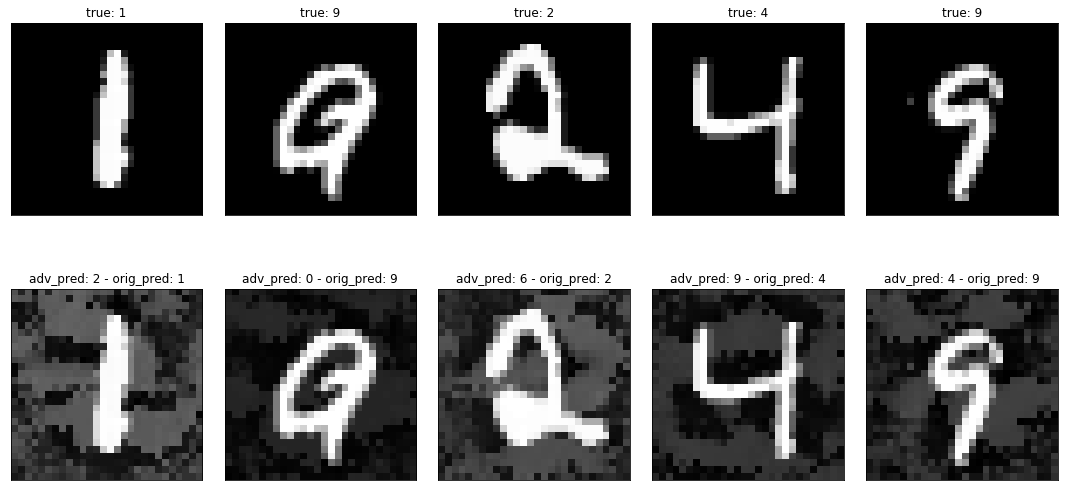

In [0]:
cw_advs_div1, div_norms1 = cw_div1_attack(model, 'relu3', 1, inputs, targets, targeted=False, confidence=0.0,
                                          c_range=(1e-3, 1e10), search_steps=1, max_steps=1000, 
                                          abort_early=True, box=box, optimizer_lr=5e-4, 
                                          init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div1)
sample_images(inputs, cw_advs_div1)

## Diversity Attack v2

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  False | Batch Divergence | Instance Divergence |

batch [0] loss: 762.6783447265625
batch [100] loss: 518.260498046875
batch [200] loss: 273.0365295410156
batch [300] loss: 110.36638641357422
batch [400] loss: 53.3310546875
batch [500] loss: 24.353069305419922
batch [600] loss: 9.01200008392334
batch [700] loss: 2.377176284790039
batch [800] loss: -9.536738616588991e-07
batch [900] loss: -9.536738616588991e-07
Perturbed Accuracy: 0/100 (0%)

Original Accuracy: 98/100 (98%)



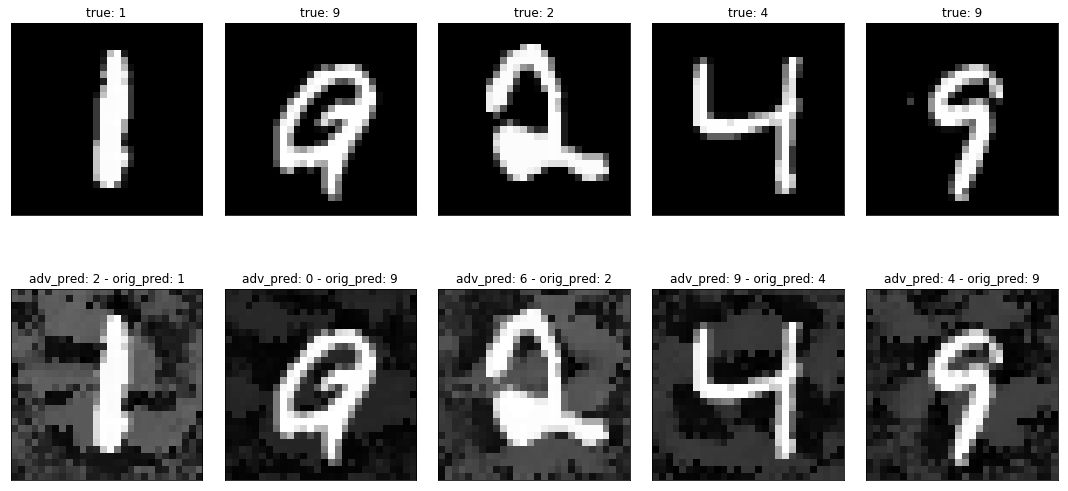

In [0]:
cw_advs_div2, div_norms2 = cw_div2_attack(model, 'relu3', 1, inputs, targets, targeted=False, confidence=0.0,
                                          c_range=(1e-3, 1e10), search_steps=1, max_steps=1000, 
                                          abort_early=True, box=box, optimizer_lr=5e-4, 
                                          init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div2)
sample_images(inputs, cw_advs_div2)

## Diversity Attack v3

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
| Cross Entropy |  False | Batch Divergence | Instance Divergence |

batch [0] loss: -0.08375522494316101
batch [100] loss: -0.2617029845714569
batch [200] loss: -2.4687092304229736
batch [300] loss: -6.165724277496338
batch [400] loss: -9.190834999084473
batch [500] loss: -11.680816650390625
batch [600] loss: -13.831015586853027
batch [700] loss: -15.781511306762695
batch [800] loss: -17.505290985107422
batch [900] loss: -19.102224349975586
Perturbed Accuracy: 4/100 (4%)

Original Accuracy: 98/100 (98%)



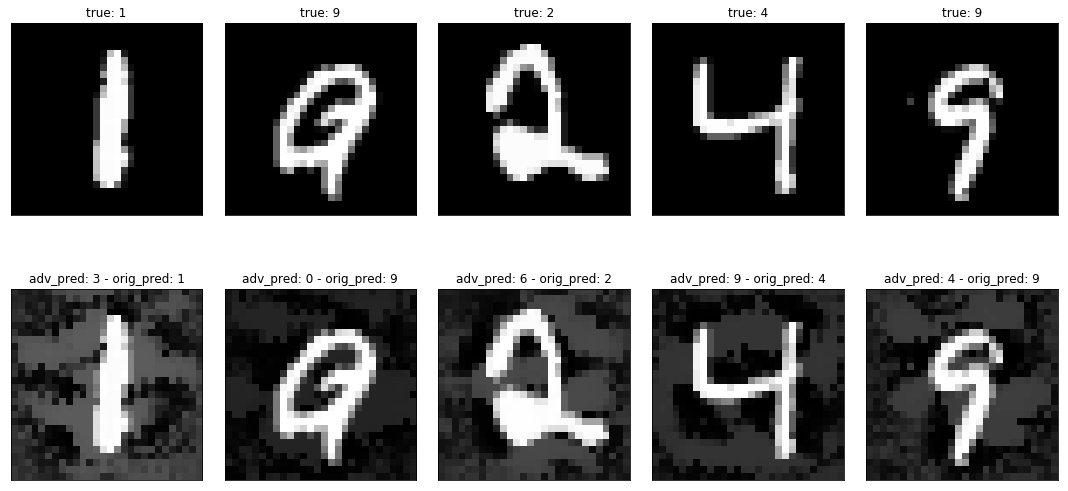

In [0]:
cw_advs_div3, div_norms3 = cw_div3_attack(model, 'relu3', 1, inputs, targets, targeted=False, confidence=0.0,
                                          c_range=(1e-3, 1e10), search_steps=1, max_steps=1000, 
                                          abort_early=True, box=box, optimizer_lr=5e-4, 
                                          init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div3)
sample_images(inputs, cw_advs_div3)

## Diversity Attack v4

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
| CW |  True | Batch Divergence | L2 |

Step 0
batch [0] loss: 0.7626774311065674
batch [100] loss: 0.5184507369995117
batch [200] loss: 0.2733131945133209
batch [300] loss: 0.11043773591518402
batch [400] loss: 0.053451668471097946
batch [500] loss: 0.02436584047973156
batch [600] loss: 0.009046967141330242
batch [700] loss: 0.002402749378234148
batch [800] loss: -9.536738616588991e-07
batch [900] loss: -9.536738616588991e-07
Perturbed Accuracy: 0/100 (0%)

Original Accuracy: 98/100 (98%)



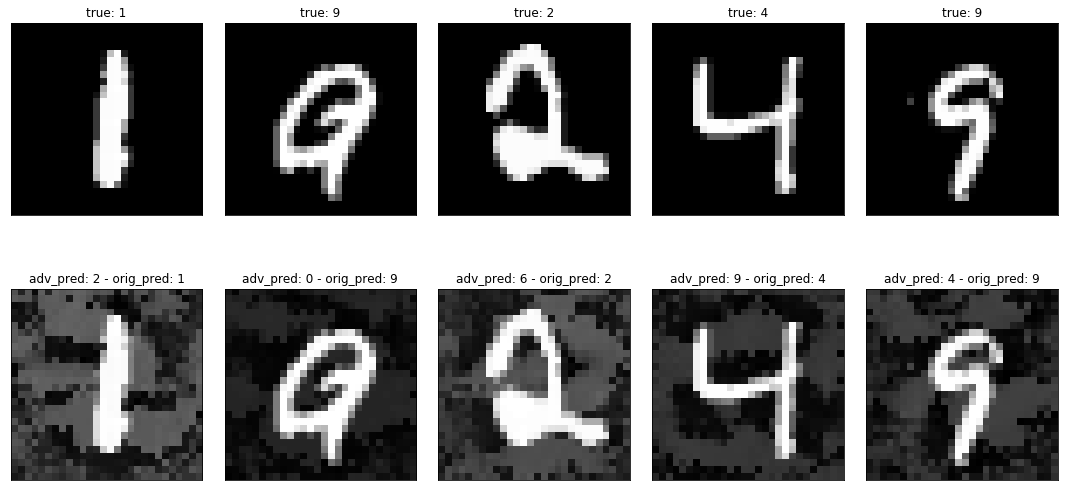

In [0]:
cw_advs_div4, l2_norms4 = cw_div4_attack(model, 'relu3', 1, inputs, targets, targeted=False, confidence=0.,
                                         c_range=(1e-3, 1e10), search_steps=1, max_steps=1000, 
                                         abort_early=True, box=box, optimizer_lr=5e-4, 
                                         init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div4)
sample_images(inputs, cw_advs_div4)

# Evaluation

timestamp 2019-07-23 00.22.16.315630 attack cw_div1_attack layer:  relu1 regularization_weight:  0
Step 0
batch [0] loss: 0.2564862370491028
batch [100] loss: 0.16551199555397034
batch [200] loss: 0.08495789021253586
batch [300] loss: 0.03220426291227341
batch [400] loss: 0.00864152517169714
batch [500] loss: 0.0021080479491502047
batch [600] loss: 0.00038879396743141115
batch [700] loss: 0.0
Step 1
batch [0] loss: 0.0
Step 2
batch [0] loss: 0.0
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


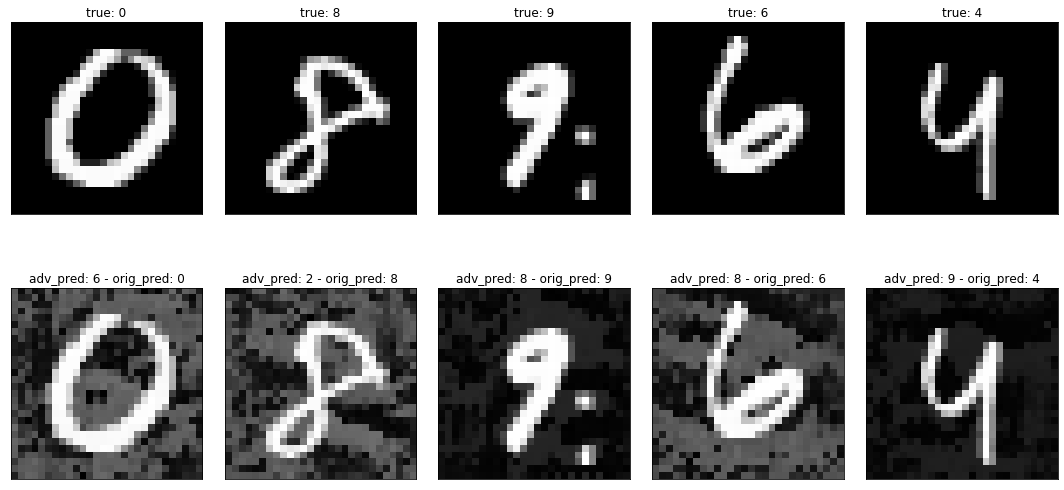

timestamp 2019-07-23 00.25.10.668484 attack cw_div1_attack layer:  relu1 regularization_weight:  0.001
Step 0
batch [0] loss: 0.2560174763202667
batch [100] loss: 0.1650056391954422
batch [200] loss: 0.08437126874923706
batch [300] loss: 0.03152516484260559
batch [400] loss: 0.007895484566688538
batch [500] loss: 0.0013134714681655169
batch [600] loss: -0.00045094540109857917
batch [700] loss: -0.0008738617179915309
batch [800] loss: -0.0009073475957848132
batch [900] loss: -0.0009454759419895709
Step 1
batch [0] loss: -0.0009779385291039944
batch [100] loss: -0.0009980931645259261
batch [200] loss: -0.0010187852894887328
batch [300] loss: -0.0010407204972580075
batch [400] loss: -0.0010664428118616343
batch [500] loss: -0.0010857695015147328
batch [600] loss: -0.0010993748437613249
batch [700] loss: -0.001117877778597176
batch [800] loss: -0.0011358431074768305
batch [900] loss: -0.0011496919905766845
Step 2
batch [0] loss: -0.0011788355186581612
batch [100] loss: -0.00118710298556834

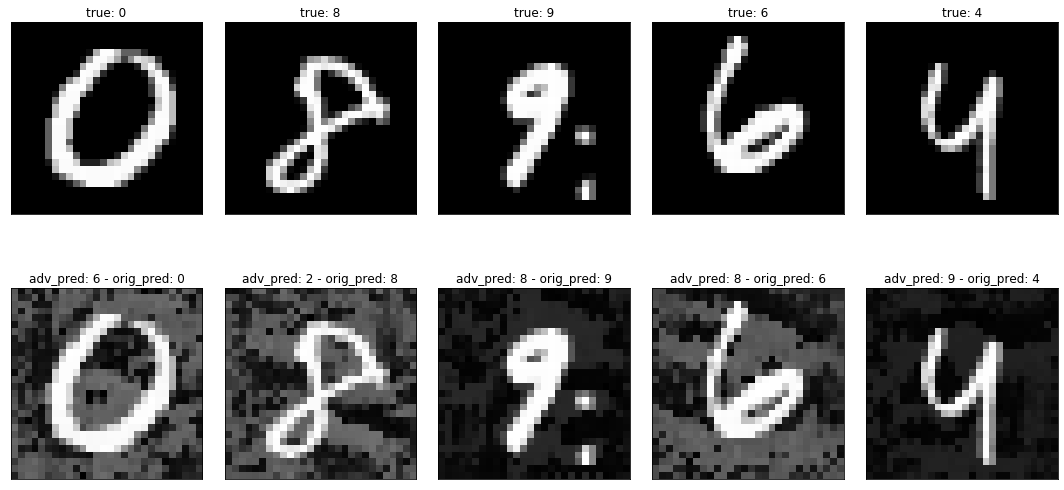

timestamp 2019-07-23 00.38.08.410492 attack cw_div1_attack layer:  relu1 regularization_weight:  0.01
Step 0
batch [0] loss: 0.25179871916770935
batch [100] loss: 0.15930244326591492
batch [200] loss: 0.07746252417564392
batch [300] loss: 0.023306747898459435
batch [400] loss: -0.0011992789804935455
batch [500] loss: -0.008201115764677525
batch [600] loss: -0.010145423002541065
batch [700] loss: -0.010752021335065365
batch [800] loss: -0.01097665075212717
batch [900] loss: -0.011213346384465694
Step 1
batch [0] loss: -0.011426407843828201
batch [100] loss: -0.011608747765421867
batch [200] loss: -0.011781131848692894
batch [300] loss: -0.011979670263826847
batch [400] loss: -0.012127520516514778
batch [500] loss: -0.012295526452362537
batch [600] loss: -0.012474197894334793
batch [700] loss: -0.012634879909455776
batch [800] loss: -0.01282857172191143
batch [900] loss: -0.013089043088257313
Step 2
batch [0] loss: -0.013200419023633003
batch [100] loss: -0.013268532231450081
batch [200]

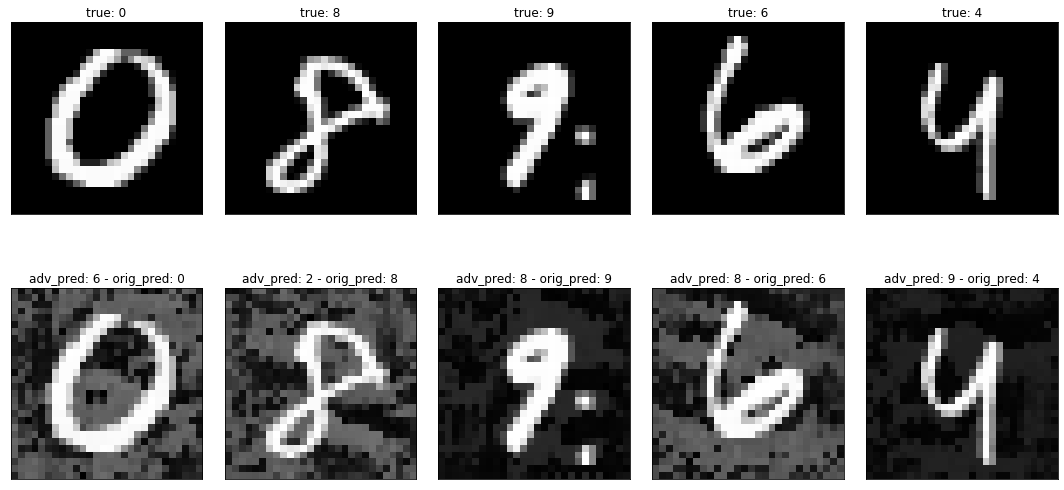

timestamp 2019-07-23 00.50.53.850010 attack cw_div1_attack layer:  relu1 regularization_weight:  1
Step 0
batch [0] loss: -0.21226608753204346
batch [100] loss: -0.5252532958984375
batch [200] loss: -0.7871764302253723
batch [300] loss: -0.9511516690254211
batch [400] loss: -1.0561599731445312
batch [500] loss: -1.1056848764419556
batch [600] loss: -1.1302211284637451
batch [700] loss: -1.1546028852462769
batch [800] loss: -1.1804455518722534
batch [900] loss: -1.2020494937896729
Step 1
batch [0] loss: -1.1936677694320679
batch [100] loss: -1.2165322303771973
batch [200] loss: -1.255852460861206
batch [300] loss: -1.2804194688796997
batch [400] loss: -1.299918532371521
batch [500] loss: -1.3121122121810913
batch [600] loss: -1.331664800643921
batch [700] loss: -1.3565267324447632
batch [800] loss: -1.3767170906066895
batch [900] loss: -1.3896265029907227
Step 2
batch [0] loss: -1.2328053712844849
batch [100] loss: -1.2958823442459106
batch [200] loss: -1.3427575826644897
batch [300] lo

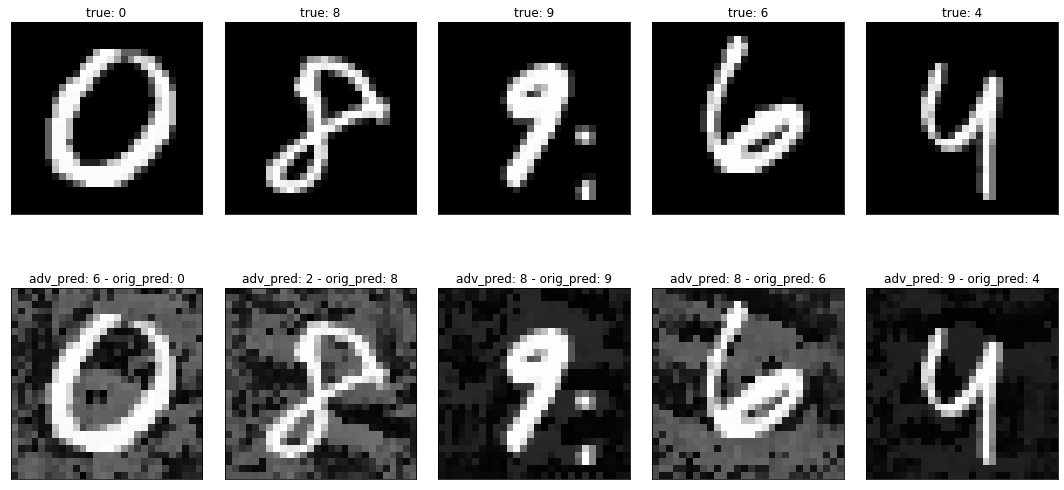

timestamp 2019-07-23 01.03.35.968606 attack cw_div1_attack layer:  relu1 regularization_weight:  10
Step 0
batch [0] loss: -4.431036949157715
batch [100] loss: -6.753177642822266
batch [200] loss: -8.657953262329102
batch [300] loss: -9.824246406555176
batch [400] loss: -10.667106628417969
batch [500] loss: -11.105330467224121
batch [600] loss: -11.341221809387207
batch [700] loss: -11.581214904785156
batch [800] loss: -11.844693183898926
batch [900] loss: -12.096416473388672
Step 1
batch [0] loss: -12.250723838806152
batch [100] loss: -12.451324462890625
batch [200] loss: -12.79171371459961
batch [300] loss: -12.992602348327637
batch [400] loss: -13.159051895141602
batch [500] loss: -13.368979454040527
batch [600] loss: -13.590420722961426
batch [700] loss: -13.681844711303711
batch [800] loss: -13.797762870788574
batch [900] loss: -13.959661483764648
Step 2
batch [0] loss: -13.839577674865723
batch [100] loss: -13.995917320251465
batch [200] loss: -14.090304374694824
batch [300] loss

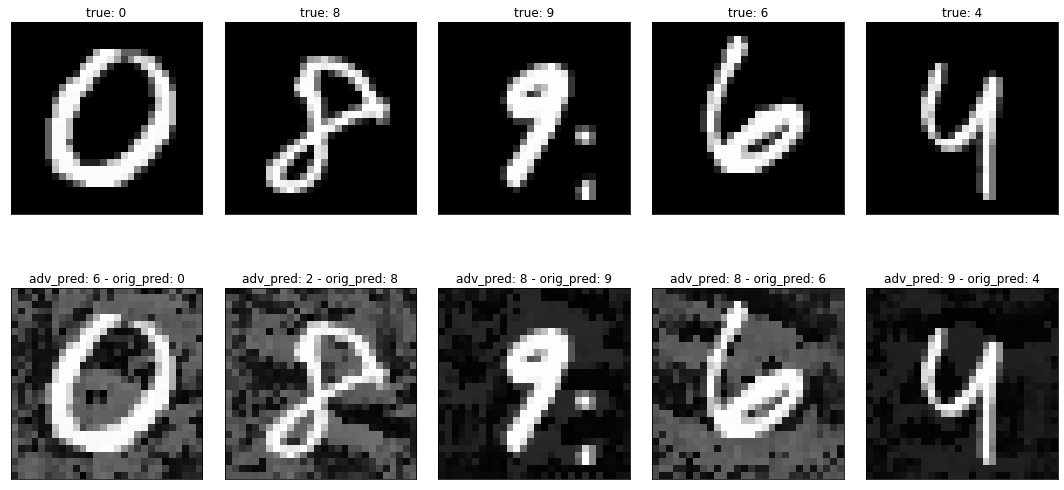

timestamp 2019-07-23 01.16.19.458115 attack cw_div1_attack layer:  relu1 regularization_weight:  100
Step 0
batch [0] loss: -46.61874771118164
batch [100] loss: -69.03312683105469
batch [200] loss: -87.36610412597656
batch [300] loss: -98.55607604980469
batch [400] loss: -106.77481079101562
batch [500] loss: -111.10102844238281
batch [600] loss: -113.44970703125
batch [700] loss: -115.86260986328125
batch [800] loss: -118.5081558227539
batch [900] loss: -121.38463592529297
Step 1
batch [0] loss: -122.84414672851562
batch [100] loss: -124.82392883300781
batch [200] loss: -128.0723419189453
batch [300] loss: -129.94943237304688
batch [400] loss: -132.31698608398438
batch [500] loss: -134.09751892089844
batch [600] loss: -136.2821502685547
batch [700] loss: -137.51071166992188
batch [800] loss: -138.9617462158203
batch [900] loss: -140.0091094970703
Step 2
batch [0] loss: -140.89134216308594
batch [100] loss: -142.1237030029297
batch [200] loss: -143.0629425048828
batch [300] loss: -144.1

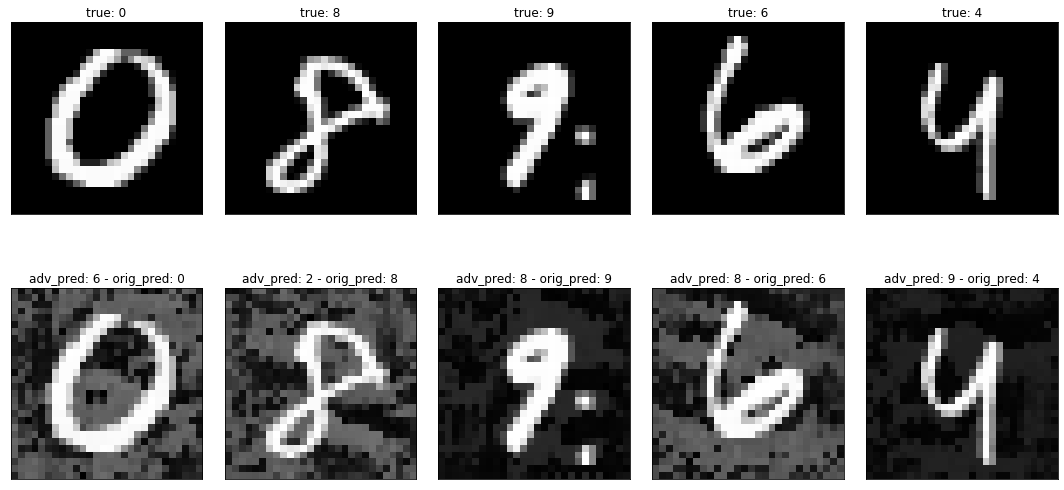

timestamp 2019-07-23 01.29.03.543100 attack cw_div1_attack layer:  relu2 regularization_weight:  0
Step 0
batch [0] loss: 0.2564862370491028
batch [100] loss: 0.1655120849609375
batch [200] loss: 0.0849582627415657
batch [300] loss: 0.03220398724079132
batch [400] loss: 0.0086418641731143
batch [500] loss: 0.0021079506259411573
batch [600] loss: 0.00038879242492839694
batch [700] loss: 0.0
Step 1
batch [0] loss: 0.0
Step 2
batch [0] loss: 0.0
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


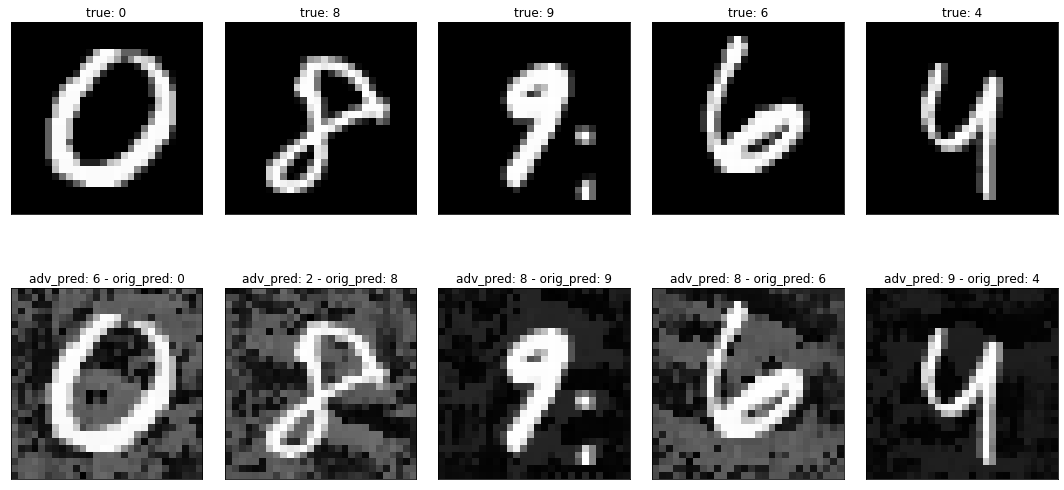

timestamp 2019-07-23 01.31.54.915175 attack cw_div1_attack layer:  relu2 regularization_weight:  0.001
Step 0
batch [0] loss: 0.2564243972301483
batch [100] loss: 0.1654571294784546
batch [200] loss: 0.08490613847970963
batch [300] loss: 0.032150860875844955
batch [400] loss: 0.008587048389017582
batch [500] loss: 0.0020506582222878933
batch [600] loss: 0.0003291129251010716
batch [700] loss: -6.301830580923706e-05
batch [800] loss: -6.63226455799304e-05
batch [900] loss: -6.98008734616451e-05
Step 1
batch [0] loss: -7.350186933763325e-05
batch [100] loss: -7.749769429210573e-05
batch [200] loss: -8.101344428723678e-05
batch [300] loss: -8.462982077617198e-05
batch [400] loss: -8.832367166178301e-05
batch [500] loss: -9.232665615854785e-05
batch [600] loss: -9.635686001274735e-05
batch [700] loss: -0.00010097290942212567
batch [800] loss: -0.00010607211879687384
batch [900] loss: -0.00011177686246810481
Step 2
batch [0] loss: -0.00011793247540481389
batch [100] loss: -0.000124763711937

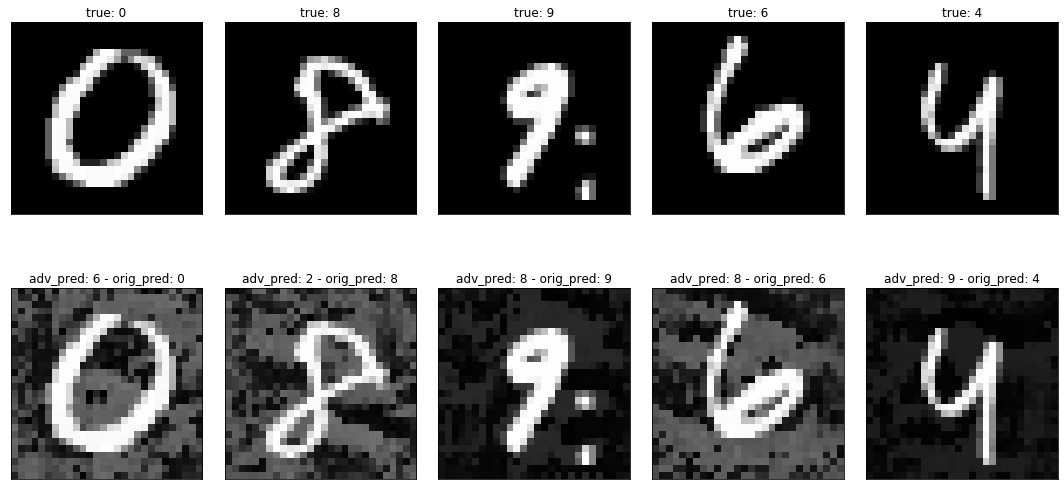

timestamp 2019-07-23 01.44.37.135415 attack cw_div1_attack layer:  relu2 regularization_weight:  0.01
Step 0
batch [0] loss: 0.2558678388595581
batch [100] loss: 0.1649196296930313
batch [200] loss: 0.08434300124645233
batch [300] loss: 0.03147266060113907
batch [400] loss: 0.007794145029038191
batch [500] loss: 0.0011369655840098858
batch [600] loss: -0.0007113727042451501
batch [700] loss: -0.0012566716177389026
batch [800] loss: -0.0014350727433338761
batch [900] loss: -0.0016424421919509768
Step 1
batch [0] loss: -0.0018748058937489986
batch [100] loss: -0.0021163614001125097
batch [200] loss: -0.0023924997076392174
batch [300] loss: -0.0033982524182647467
batch [400] loss: -0.0035969531163573265
batch [500] loss: -0.0038215576205402613
batch [600] loss: -0.004078616388142109
batch [700] loss: -0.004355533979833126
batch [800] loss: -0.005233396776020527
batch [900] loss: -0.005358319263905287
Step 2
batch [0] loss: -0.005479562561959028
batch [100] loss: -0.005566844251006842
batc

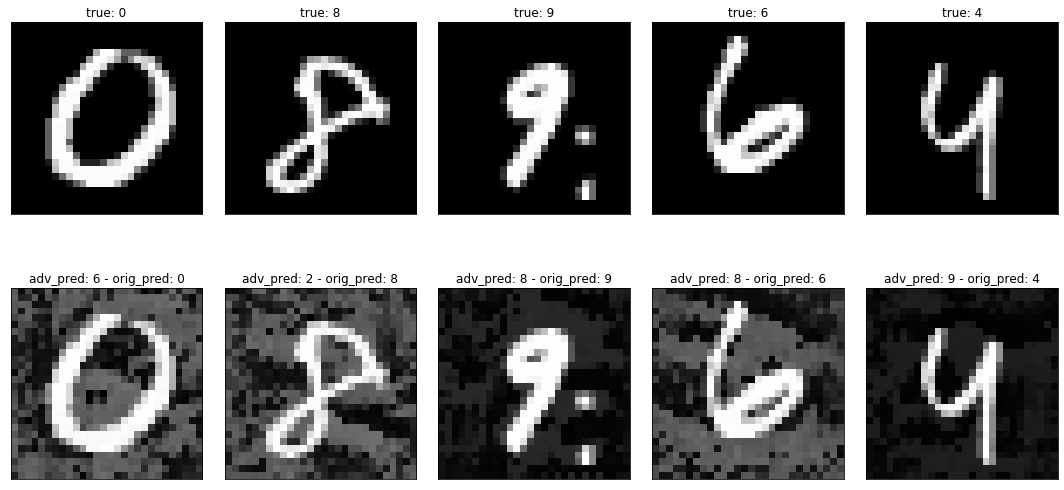

timestamp 2019-07-23 01.57.17.971222 attack cw_div1_attack layer:  relu2 regularization_weight:  1
Step 0
batch [0] loss: 0.19464635848999023
batch [100] loss: 0.08410952985286713
batch [200] loss: -0.02158135175704956
batch [300] loss: -0.10642711073160172
batch [400] loss: -0.17013579607009888
batch [500] loss: -0.21800380945205688
batch [600] loss: -0.27048414945602417
batch [700] loss: -0.44885480403900146
batch [800] loss: -0.4603293538093567
batch [900] loss: -0.47197115421295166
Step 1
batch [0] loss: -0.47865235805511475
batch [100] loss: -0.49592125415802
batch [200] loss: -0.5055986642837524
batch [300] loss: -0.5145057439804077
batch [400] loss: -0.5224186778068542
batch [500] loss: -0.530903160572052
batch [600] loss: -0.5390804409980774
batch [700] loss: -0.5459352135658264
batch [800] loss: -0.5522527098655701
batch [900] loss: -0.5585635304450989
Step 2
batch [0] loss: -0.5631054639816284
batch [100] loss: -0.5691460967063904
batch [200] loss: -0.5746727585792542
batch [

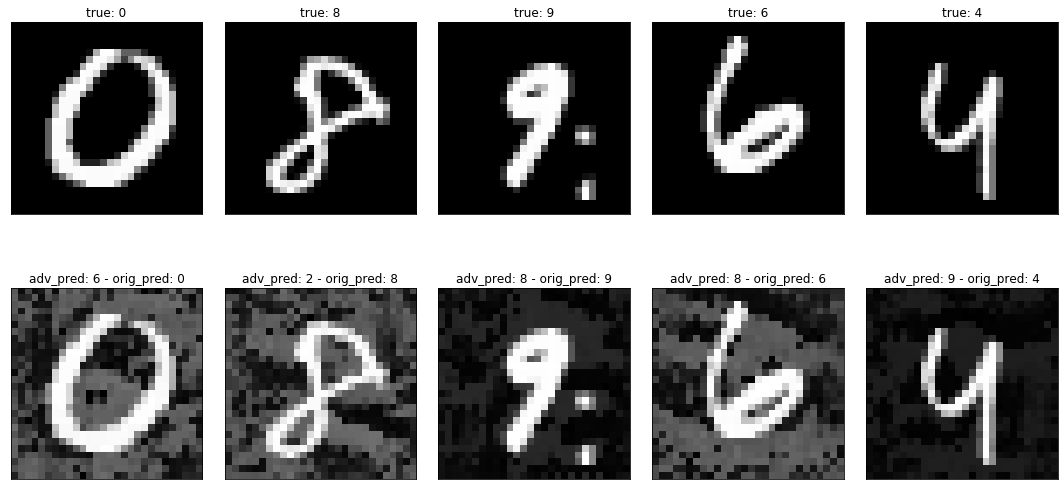

timestamp 2019-07-23 02.10.00.548974 attack cw_div1_attack layer:  relu2 regularization_weight:  10
Step 0
batch [0] loss: -0.3619126081466675
batch [100] loss: -0.6572155356407166
batch [200] loss: -0.9995568990707397
batch [300] loss: -1.3738336563110352
batch [400] loss: -1.7919495105743408
batch [500] loss: -2.1880245208740234
batch [600] loss: -2.645754814147949
batch [700] loss: -3.8372550010681152
batch [800] loss: -4.643621921539307
batch [900] loss: -4.749344825744629
Step 1
batch [0] loss: -4.855436325073242
batch [100] loss: -4.9587273597717285
batch [200] loss: -5.0630412101745605
batch [300] loss: -5.15685510635376
batch [400] loss: -5.239312648773193
batch [500] loss: -5.316133499145508
batch [600] loss: -5.393735885620117
batch [700] loss: -5.457043170928955
batch [800] loss: -5.520420074462891
batch [900] loss: -5.584968566894531
Step 2
batch [0] loss: -5.642056941986084
batch [100] loss: -5.696259498596191
batch [200] loss: -5.7552595138549805
batch [300] loss: -5.7936

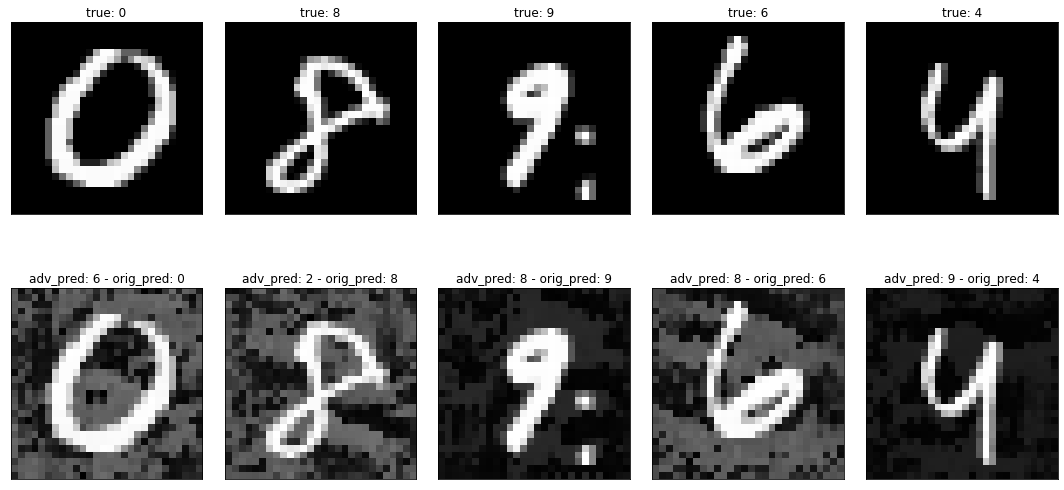

timestamp 2019-07-23 02.22.46.212048 attack cw_div1_attack layer:  relu2 regularization_weight:  100
Step 0
batch [0] loss: -5.927501678466797
batch [100] loss: -8.069629669189453
batch [200] loss: -10.778707504272461
batch [300] loss: -14.008964538574219
batch [400] loss: -18.050355911254883
batch [500] loss: -22.036039352416992
batch [600] loss: -26.978748321533203
batch [700] loss: -40.846229553222656
batch [800] loss: -46.42050552368164
batch [900] loss: -47.567054748535156
Step 1
batch [0] loss: -48.63425064086914
batch [100] loss: -49.645179748535156
batch [200] loss: -50.65290069580078
batch [300] loss: -51.56776428222656
batch [400] loss: -52.336090087890625
batch [500] loss: -53.15222930908203
batch [600] loss: -53.9393424987793
batch [700] loss: -54.708091735839844
batch [800] loss: -55.34604263305664
batch [900] loss: -55.90666961669922
Step 2
batch [0] loss: -56.51164627075195
batch [100] loss: -57.154537200927734
batch [200] loss: -57.650779724121094
batch [300] loss: -58.

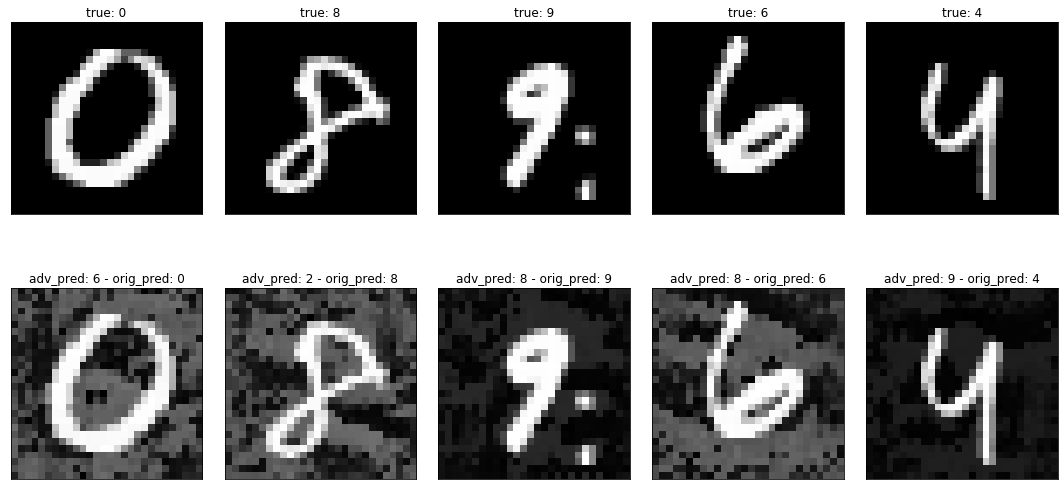

timestamp 2019-07-23 02.35.26.870313 attack cw_div1_attack layer:  relu3 regularization_weight:  0
Step 0
batch [0] loss: 0.2564862370491028
batch [100] loss: 0.1655120849609375
batch [200] loss: 0.08495780825614929
batch [300] loss: 0.03220490366220474
batch [400] loss: 0.008641853928565979
batch [500] loss: 0.0021078421268612146
batch [600] loss: 0.0003888037463184446
batch [700] loss: 0.0
Step 1
batch [0] loss: 0.0
Step 2
batch [0] loss: 0.0
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


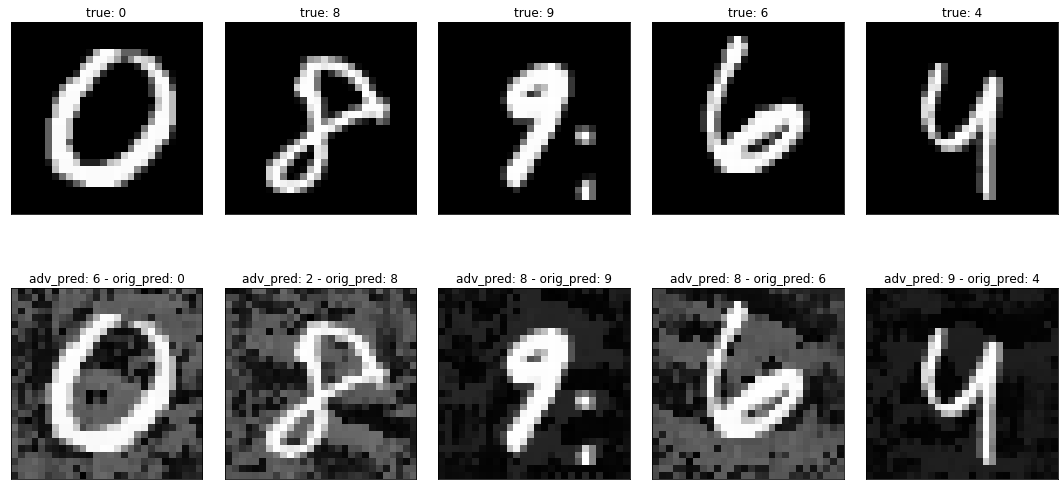

timestamp 2019-07-23 02.38.16.266782 attack cw_div1_attack layer:  relu3 regularization_weight:  0.001
Step 0
batch [0] loss: 0.2564862370491028
batch [100] loss: 0.16551198065280914
batch [200] loss: 0.08495814353227615
batch [300] loss: 0.03220387548208237
batch [400] loss: 0.008641911670565605
batch [500] loss: 0.0021078186109662056
batch [600] loss: 0.0003890139050781727
batch [700] loss: 9.536739176141396e-10
batch [800] loss: 9.536739176141396e-10
Step 1
batch [0] loss: 9.536739176141396e-10
batch [100] loss: 9.536739176141396e-10
Step 2
batch [0] loss: 9.536739176141396e-10
batch [100] loss: 9.536739176141396e-10
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


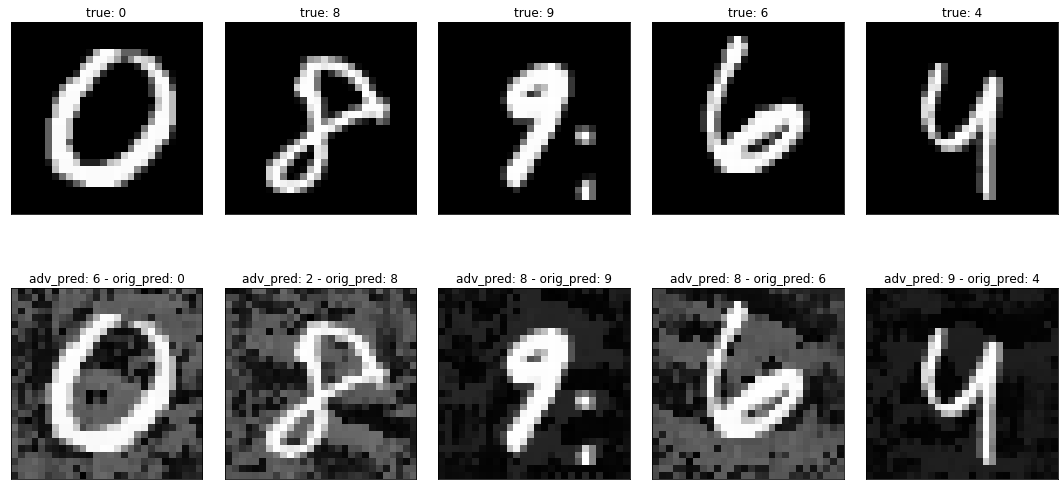

timestamp 2019-07-23 02.42.22.392497 attack cw_div1_attack layer:  relu3 regularization_weight:  0.01
Step 0
batch [0] loss: 0.2564862370491028
batch [100] loss: 0.16551204025745392
batch [200] loss: 0.08495762944221497
batch [300] loss: 0.032204821705818176
batch [400] loss: 0.008641842752695084
batch [500] loss: 0.0021080742590129375
batch [600] loss: 0.00038880339707247913
batch [700] loss: 9.53673851000758e-09
batch [800] loss: 9.53673851000758e-09
Step 1
batch [0] loss: 9.53673851000758e-09
batch [100] loss: 9.53673851000758e-09
Step 2
batch [0] loss: 9.53673851000758e-09
batch [100] loss: 9.53673851000758e-09
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


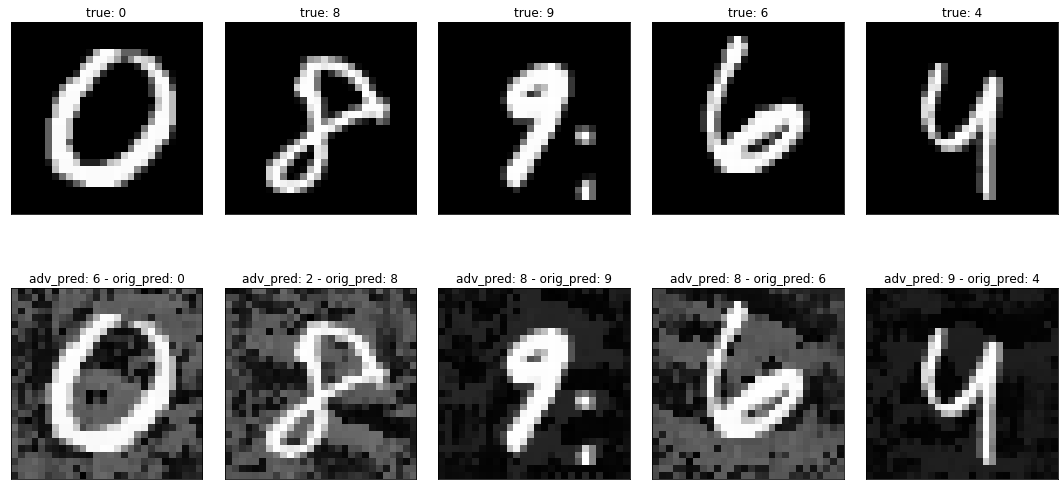

timestamp 2019-07-23 02.46.28.931379 attack cw_div1_attack layer:  relu3 regularization_weight:  1
Step 0
batch [0] loss: 0.2564871907234192
batch [100] loss: 0.16551290452480316
batch [200] loss: 0.08495835959911346
batch [300] loss: 0.03220488131046295
batch [400] loss: 0.008642807602882385
batch [500] loss: 0.0021087448112666607
batch [600] loss: 0.00039002063567750156
batch [700] loss: 9.536738616588991e-07
batch [800] loss: 9.536738616588991e-07
Step 1
batch [0] loss: 9.536738616588991e-07
batch [100] loss: 9.536738616588991e-07
Step 2
batch [0] loss: 9.536738616588991e-07
batch [100] loss: 9.536738616588991e-07
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


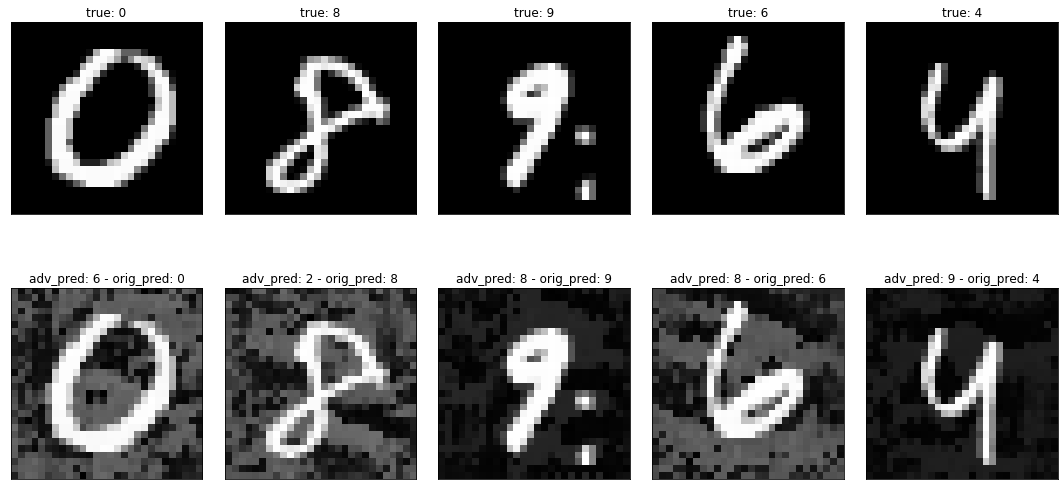

timestamp 2019-07-23 02.50.34.424431 attack cw_div1_attack layer:  relu3 regularization_weight:  10
Step 0
batch [0] loss: 0.25649577379226685
batch [100] loss: 0.16552159190177917
batch [200] loss: 0.08496728539466858
batch [300] loss: 0.032214127480983734
batch [400] loss: 0.008651155047118664
batch [500] loss: 0.0021173707209527493
batch [600] loss: 0.0003984047216363251
batch [700] loss: 9.536738616588991e-06
batch [800] loss: 9.536738616588991e-06
Step 1
batch [0] loss: 9.536738616588991e-06
batch [100] loss: 9.536738616588991e-06
Step 2
batch [0] loss: 9.536738616588991e-06
batch [100] loss: 9.536738616588991e-06
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


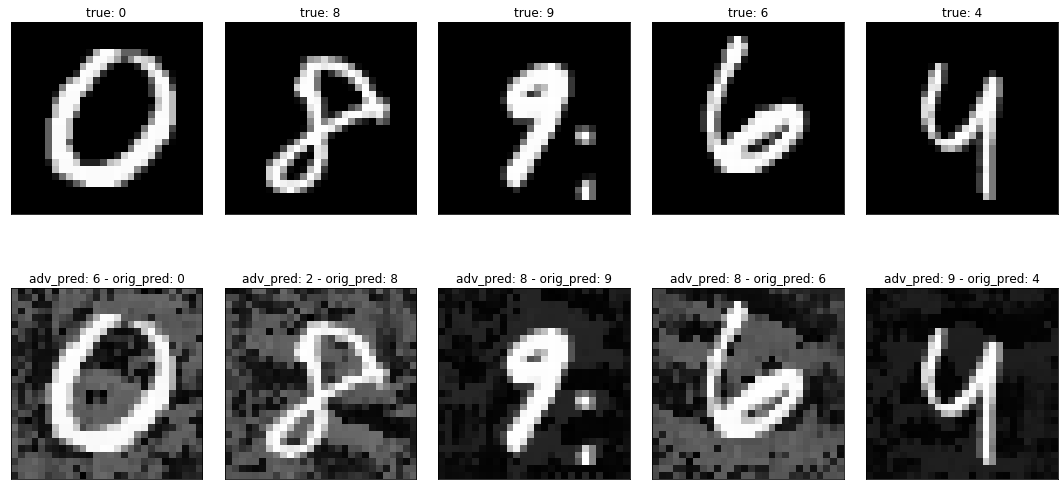

timestamp 2019-07-23 02.54.40.856066 attack cw_div1_attack layer:  relu3 regularization_weight:  100
Step 0
batch [0] loss: 0.2565816044807434
batch [100] loss: 0.16560743749141693
batch [200] loss: 0.08505288511514664
batch [300] loss: 0.032299332320690155
batch [400] loss: 0.008736727759242058
batch [500] loss: 0.002203321782872081
batch [600] loss: 0.0004841610207222402
batch [700] loss: 9.536738798487931e-05
batch [800] loss: 9.536738798487931e-05
Step 1
batch [0] loss: 9.536738798487931e-05
batch [100] loss: 9.536738798487931e-05
Step 2
batch [0] loss: 9.536738798487931e-05
batch [100] loss: 9.536738798487931e-05
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


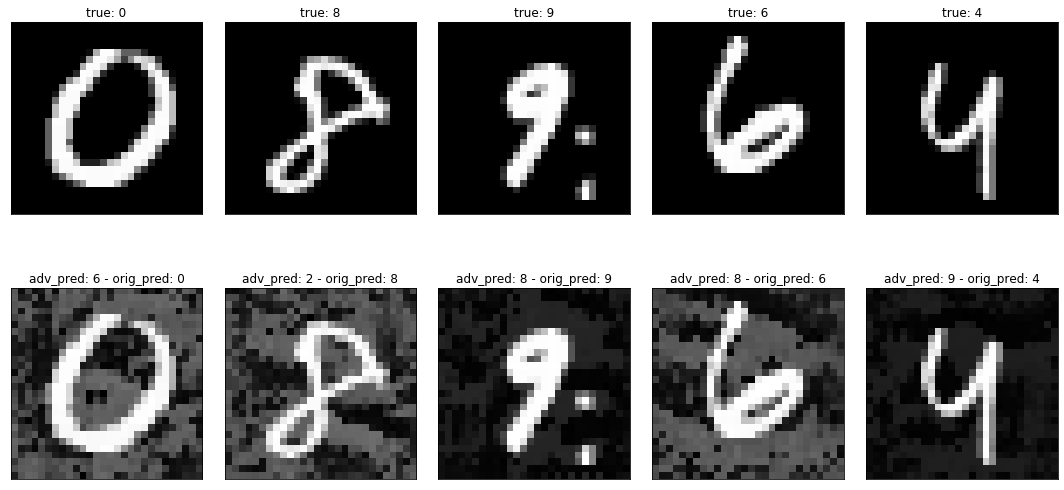

timestamp 2019-07-23 02.58.47.455276 attack cw_div2_attack layer:  relu1 regularization_weight:  0
batch [0] loss: 256.4862060546875
batch [100] loss: 165.29644775390625
batch [200] loss: 84.72470092773438
batch [300] loss: 32.03860855102539
batch [400] loss: 8.600440979003906
batch [500] loss: 2.0735926628112793
batch [600] loss: 0.3623887300491333
batch [700] loss: 0.0
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


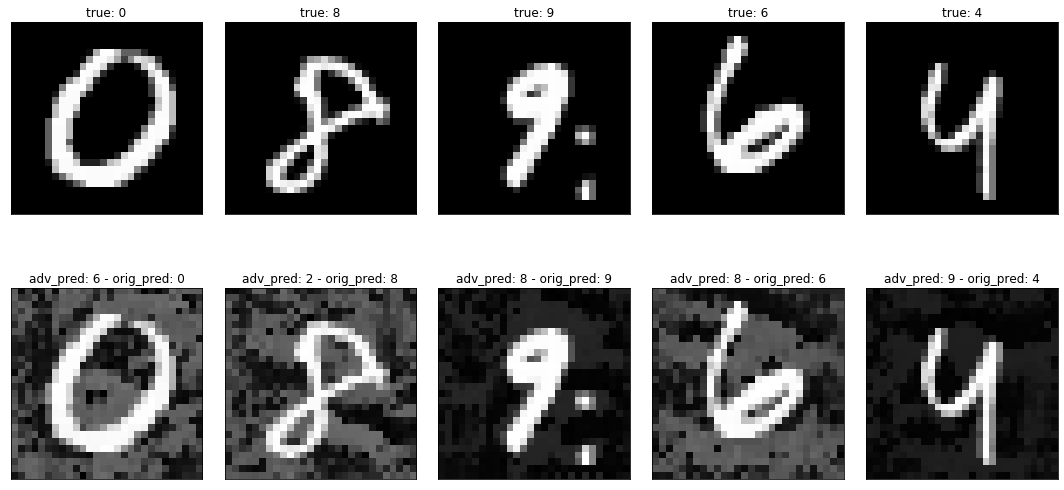

timestamp 2019-07-23 03.01.37.852322 attack cw_div2_attack layer:  relu1 regularization_weight:  0.001
batch [0] loss: 256.4866638183594
batch [100] loss: 165.29931640625
batch [200] loss: 84.71604919433594
batch [300] loss: 32.031944274902344
batch [400] loss: 8.600340843200684
batch [500] loss: 2.074040174484253
batch [600] loss: 0.3629051446914673
batch [700] loss: 0.0004460049094632268
batch [800] loss: 0.00044566718861460686
batch [900] loss: 0.00044529844308272004
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


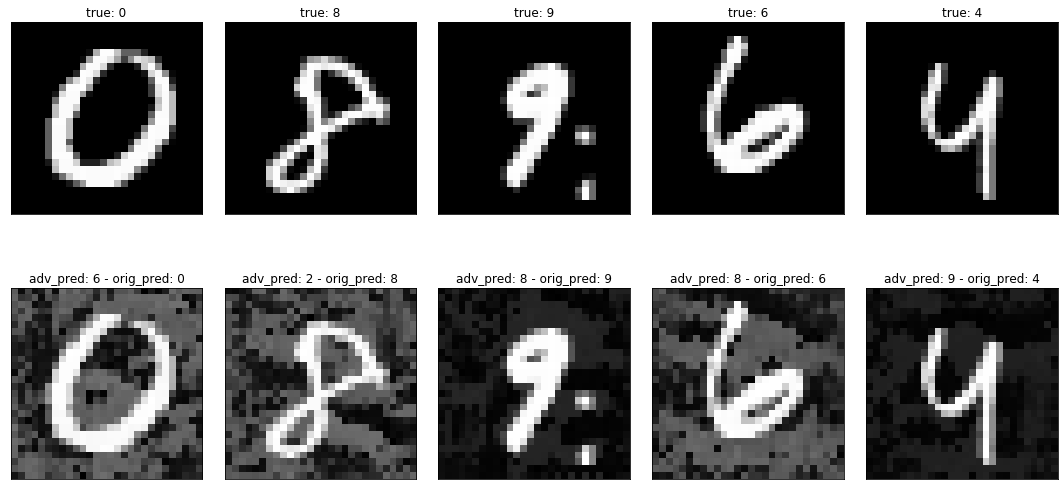

timestamp 2019-07-23 03.06.02.396715 attack cw_div2_attack layer:  relu1 regularization_weight:  0.01
batch [0] loss: 256.49090576171875
batch [100] loss: 165.3037872314453
batch [200] loss: 84.72891235351562
batch [300] loss: 32.042510986328125
batch [400] loss: 8.604747772216797
batch [500] loss: 2.0773775577545166
batch [600] loss: 0.3666851818561554
batch [700] loss: 0.0043458943255245686
batch [800] loss: 0.004313043784350157
batch [900] loss: 0.004277834668755531
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


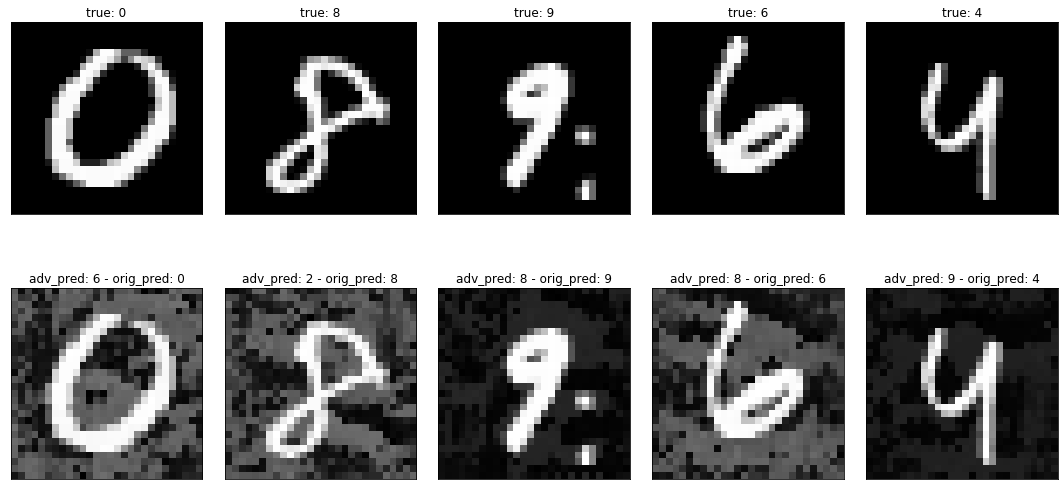

timestamp 2019-07-23 03.10.12.433475 attack cw_div2_attack layer:  relu1 regularization_weight:  1
batch [0] loss: 256.9549560546875
batch [100] loss: 165.7356414794922
batch [200] loss: 85.06652069091797
batch [300] loss: 32.31605529785156
batch [400] loss: 8.83932113647461
batch [500] loss: 2.2807931900024414
batch [600] loss: 0.54453444480896
batch [700] loss: 0.16252943873405457
batch [800] loss: 0.14670512080192566
batch [900] loss: 0.13343799114227295
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


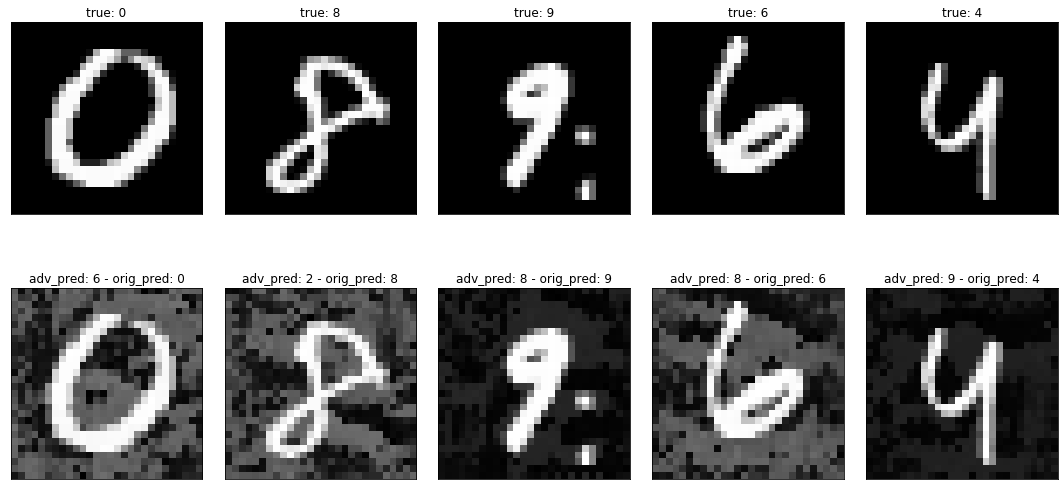

timestamp 2019-07-23 03.14.22.279647 attack cw_div2_attack layer:  relu1 regularization_weight:  10
batch [0] loss: 261.1737365722656
batch [100] loss: 168.84844970703125
batch [200] loss: 87.52076721191406
batch [300] loss: 33.97394561767578
batch [400] loss: 10.166494369506836
batch [500] loss: 3.382169485092163
batch [600] loss: 1.4770034551620483
batch [700] loss: 0.9628114700317383
batch [800] loss: 0.840522289276123
batch [900] loss: 0.7393687963485718
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


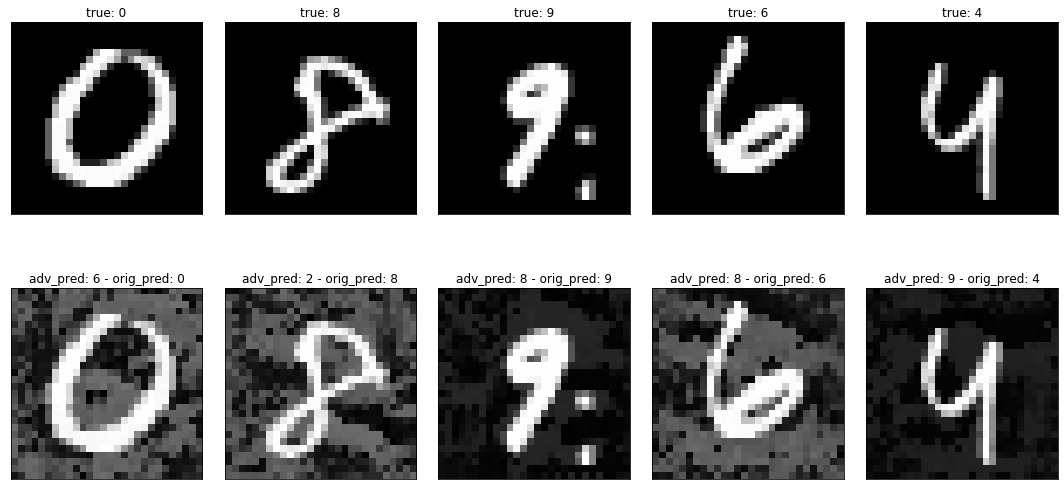

timestamp 2019-07-23 03.18.30.672462 attack cw_div2_attack layer:  relu1 regularization_weight:  100
batch [0] loss: 303.3614501953125
batch [100] loss: 198.02993774414062
batch [200] loss: 108.91726684570312
batch [300] loss: 50.380165100097656
batch [400] loss: 22.840484619140625
batch [500] loss: 13.530375480651855
batch [600] loss: 9.807535171508789
batch [700] loss: 7.888895034790039
batch [800] loss: 6.655089378356934
batch [900] loss: 5.659233570098877
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


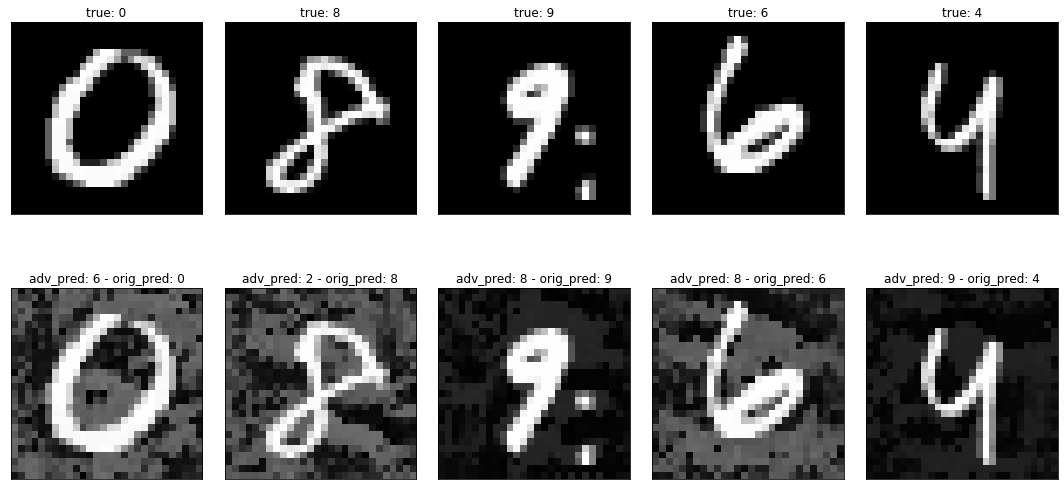

timestamp 2019-07-23 03.22.38.745732 attack cw_div2_attack layer:  relu2 regularization_weight:  0
batch [0] loss: 256.4862060546875
batch [100] loss: 165.29196166992188
batch [200] loss: 84.72459411621094
batch [300] loss: 32.03863525390625
batch [400] loss: 8.600476264953613
batch [500] loss: 2.0737462043762207
batch [600] loss: 0.36228930950164795
batch [700] loss: 0.0
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


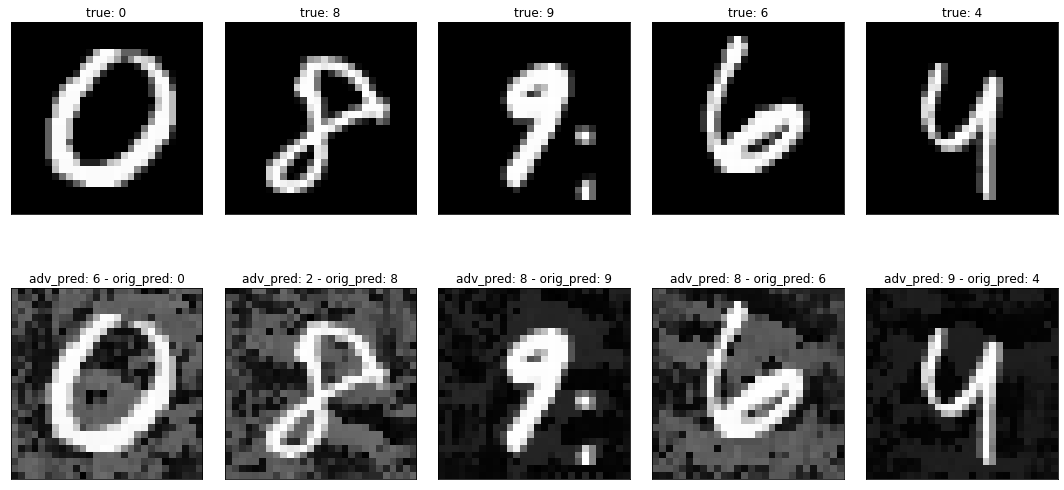

timestamp 2019-07-23 03.25.28.658825 attack cw_div2_attack layer:  relu2 regularization_weight:  0.001
batch [0] loss: 256.48626708984375
batch [100] loss: 165.29103088378906
batch [200] loss: 84.7385025024414
batch [300] loss: 32.03853988647461
batch [400] loss: 8.600497245788574
batch [500] loss: 2.073265790939331
batch [600] loss: 0.36253929138183594
batch [700] loss: 5.0650596676860005e-05
batch [800] loss: 5.064808647148311e-05
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


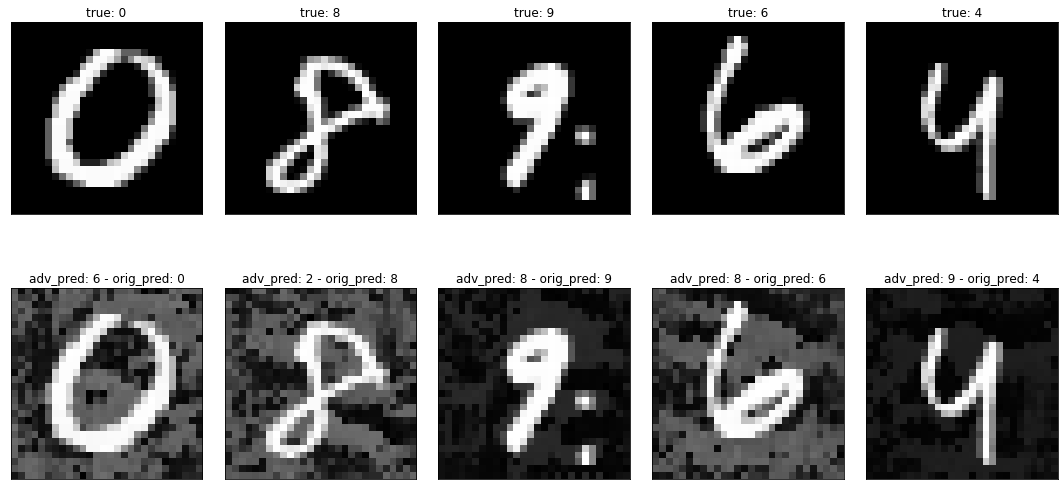

timestamp 2019-07-23 03.28.46.186796 attack cw_div2_attack layer:  relu2 regularization_weight:  0.01
batch [0] loss: 256.48681640625
batch [100] loss: 165.297119140625
batch [200] loss: 84.7250747680664
batch [300] loss: 32.03868103027344
batch [400] loss: 8.600796699523926
batch [500] loss: 2.074066400527954
batch [600] loss: 0.36285141110420227
batch [700] loss: 0.000505729578435421
batch [800] loss: 0.0005054769571870565
batch [900] loss: 0.0005052025080658495
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


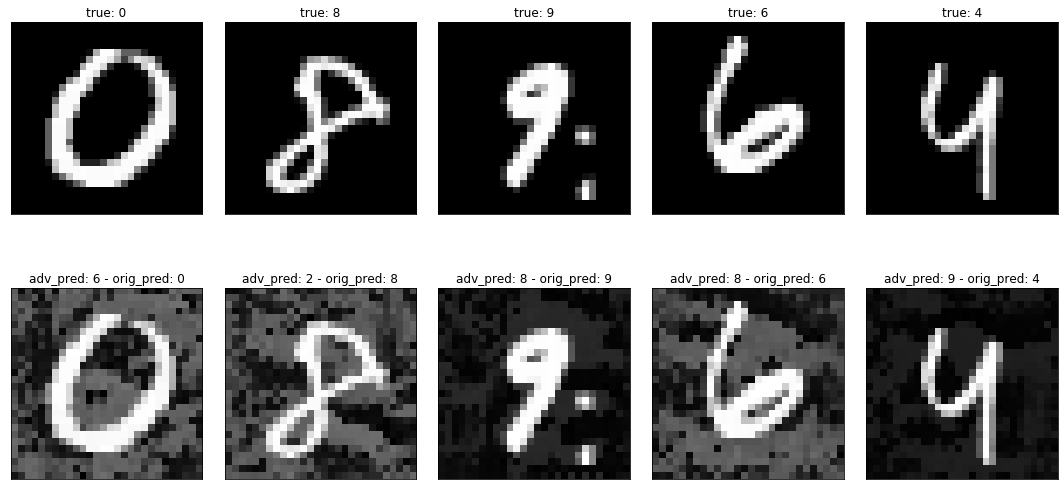

timestamp 2019-07-23 03.32.54.124251 attack cw_div2_attack layer:  relu2 regularization_weight:  1
batch [0] loss: 256.54803466796875
batch [100] loss: 165.35153198242188
batch [200] loss: 84.78795623779297
batch [300] loss: 32.08692169189453
batch [400] loss: 8.648476600646973
batch [500] loss: 2.1214306354522705
batch [600] loss: 0.40868836641311646
batch [700] loss: 0.0430617593228817
batch [800] loss: 0.0415339469909668
batch [900] loss: 0.040089238435029984
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


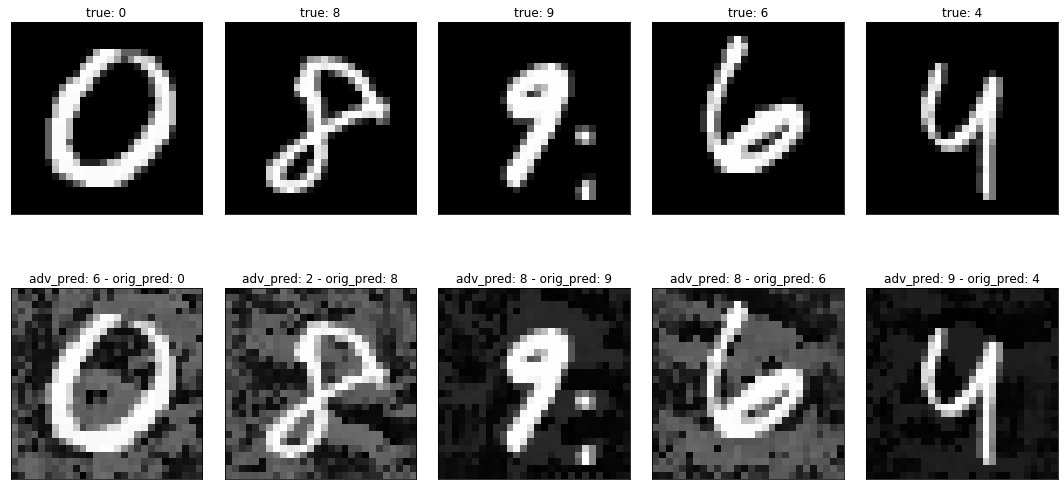

timestamp 2019-07-23 03.37.01.176314 attack cw_div2_attack layer:  relu2 regularization_weight:  10
batch [0] loss: 257.1046142578125
batch [100] loss: 165.85414123535156
batch [200] loss: 85.18597412109375
batch [300] loss: 32.430030822753906
batch [400] loss: 8.95105266571045
batch [500] loss: 2.3834757804870605
batch [600] loss: 0.636694073677063
batch [700] loss: 0.2431625872850418
batch [800] loss: 0.2156362682580948
batch [900] loss: 0.19167393445968628
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


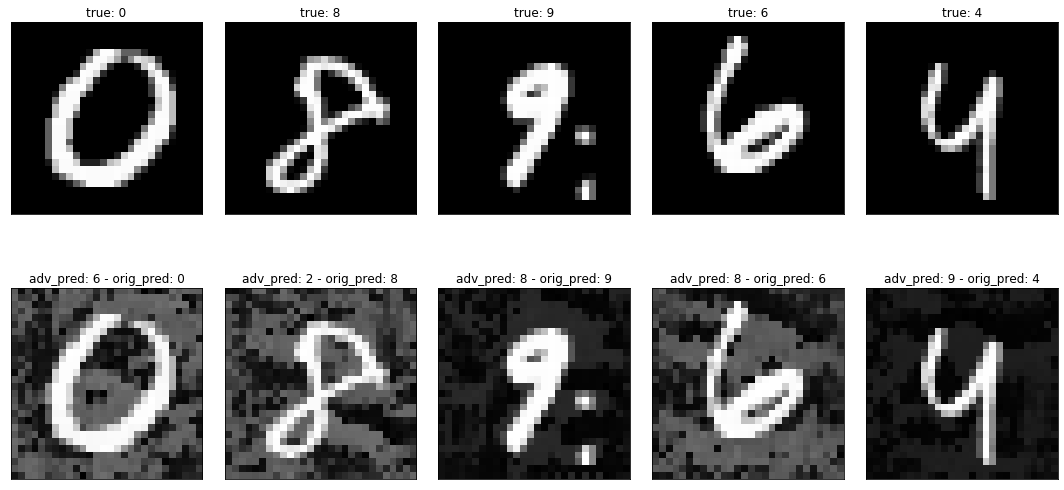

timestamp 2019-07-23 03.41.08.912595 attack cw_div2_attack layer:  relu2 regularization_weight:  100
batch [0] loss: 262.6701965332031
batch [100] loss: 170.35972595214844
batch [200] loss: 88.70563507080078
batch [300] loss: 34.728153228759766
batch [400] loss: 10.696268081665039
batch [500] loss: 3.7599000930786133
batch [600] loss: 1.7396377325057983
batch [700] loss: 1.1367533206939697
batch [800] loss: 0.9536039233207703
batch [900] loss: 0.8122187256813049
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


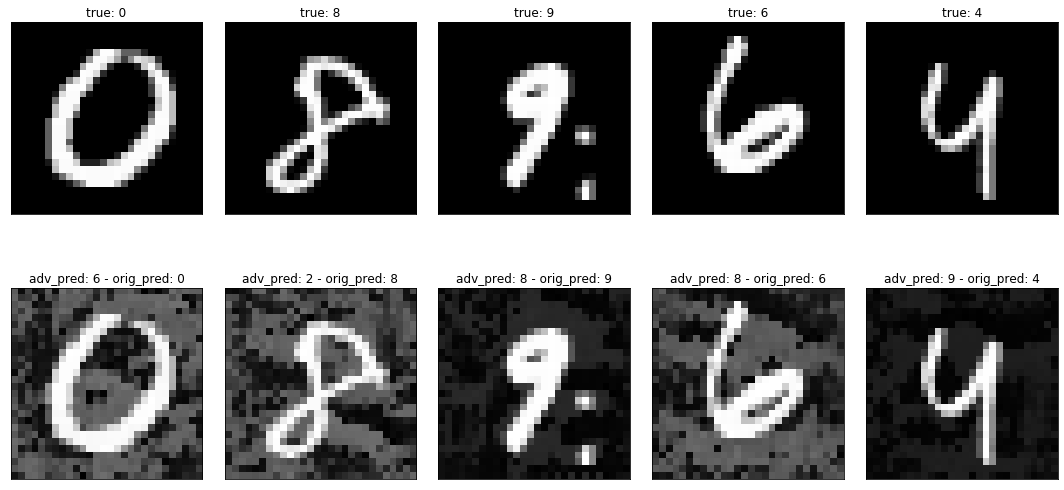

timestamp 2019-07-23 03.45.16.207450 attack cw_div2_attack layer:  relu3 regularization_weight:  0
batch [0] loss: 256.4862060546875
batch [100] loss: 165.29644775390625
batch [200] loss: 84.71459197998047
batch [300] loss: 32.03108596801758
batch [400] loss: 8.600248336791992
batch [500] loss: 2.0755128860473633
batch [600] loss: 0.36411380767822266
batch [700] loss: 0.0
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


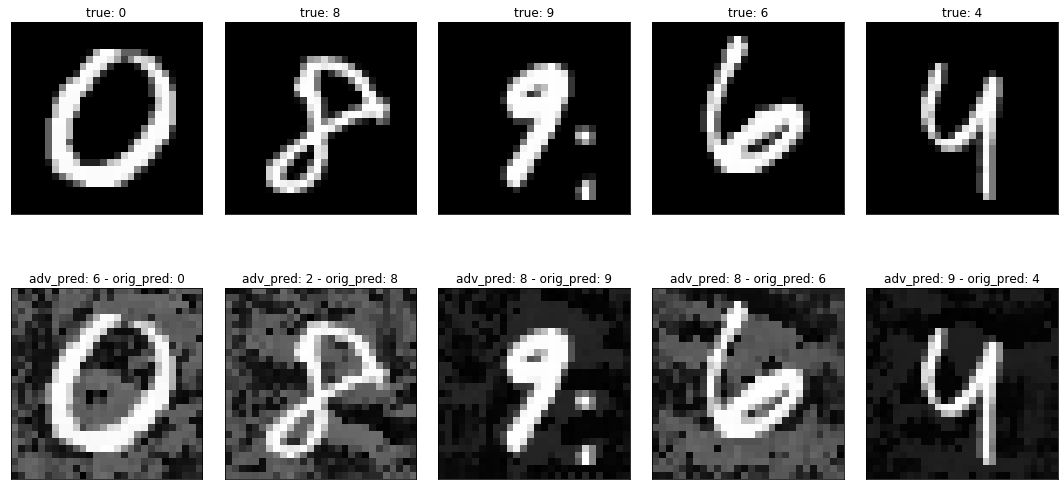

timestamp 2019-07-23 03.48.05.215679 attack cw_div2_attack layer:  relu3 regularization_weight:  0.001
batch [0] loss: 256.4862060546875
batch [100] loss: 165.2919464111328
batch [200] loss: 84.72445678710938
batch [300] loss: 32.03837203979492
batch [400] loss: 8.600324630737305
batch [500] loss: 2.0731453895568848
batch [600] loss: 0.3623455762863159
batch [700] loss: -9.536739176141396e-10
batch [800] loss: -9.536739176141396e-10
batch [900] loss: -9.536739176141396e-10
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


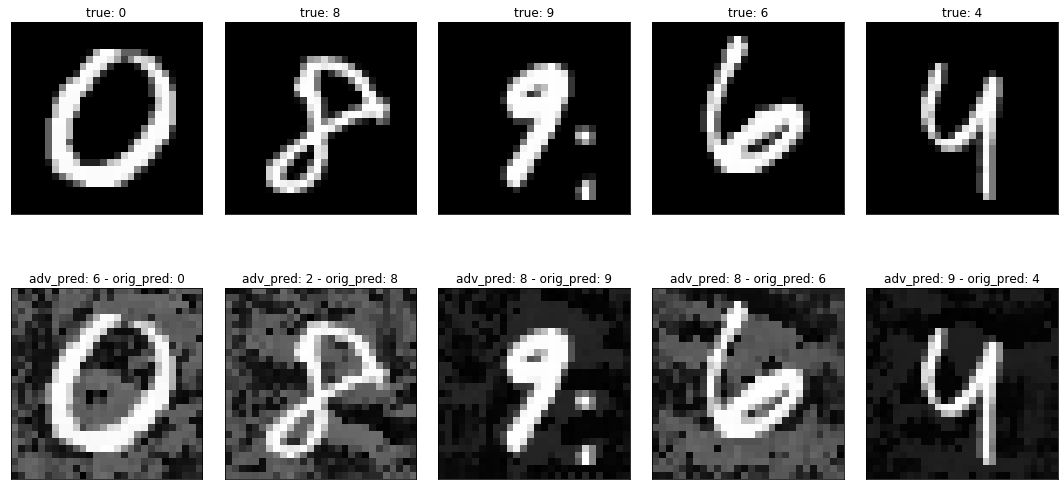

timestamp 2019-07-23 03.52.09.997799 attack cw_div2_attack layer:  relu3 regularization_weight:  0.01
batch [0] loss: 256.4862060546875
batch [100] loss: 165.2964324951172
batch [200] loss: 84.7243881225586
batch [300] loss: 32.038082122802734
batch [400] loss: 8.600537300109863
batch [500] loss: 2.073150634765625
batch [600] loss: 0.3623088598251343
batch [700] loss: -9.53673851000758e-09
batch [800] loss: -9.53673851000758e-09
batch [900] loss: -9.53673851000758e-09
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


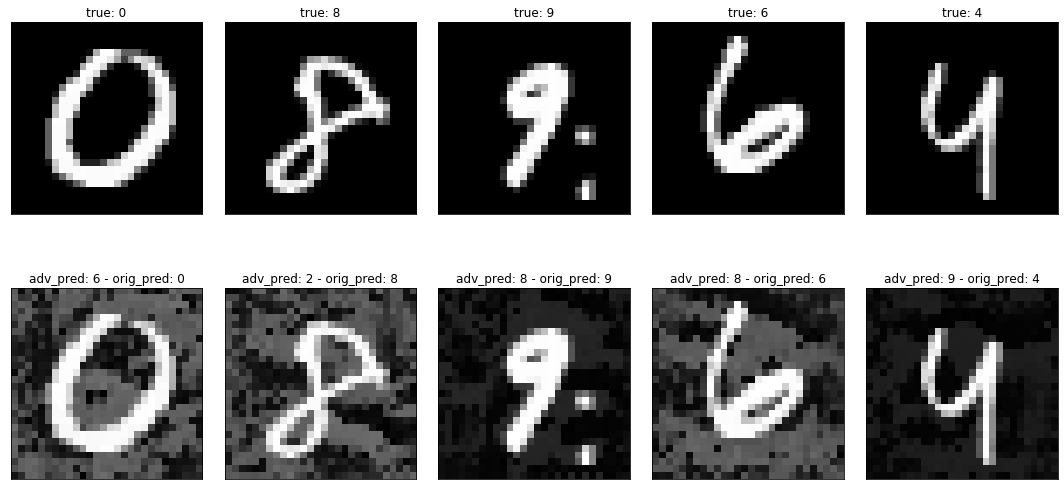

timestamp 2019-07-23 03.56.14.592955 attack cw_div2_attack layer:  relu3 regularization_weight:  1
batch [0] loss: 256.4862060546875
batch [100] loss: 165.29653930664062
batch [200] loss: 84.7155990600586
batch [300] loss: 32.03154754638672
batch [400] loss: 8.599918365478516
batch [500] loss: 2.0735714435577393
batch [600] loss: 0.3622884750366211
batch [700] loss: -9.536738616588991e-07
batch [800] loss: -9.536738616588991e-07
batch [900] loss: -9.536738616588991e-07
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


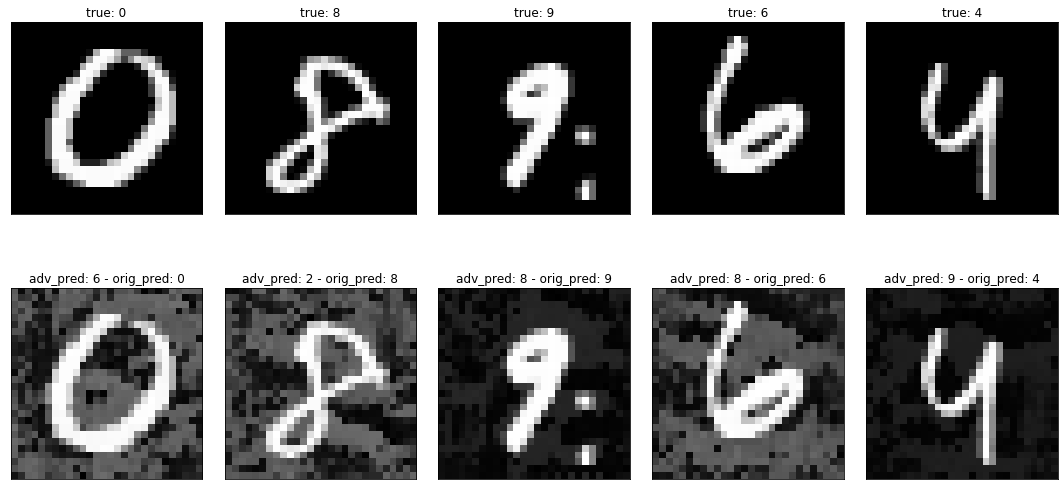

timestamp 2019-07-23 04.00.19.507945 attack cw_div2_attack layer:  relu3 regularization_weight:  10
batch [0] loss: 256.4862060546875
batch [100] loss: 165.29202270507812
batch [200] loss: 84.71509552001953
batch [300] loss: 32.03121566772461
batch [400] loss: 8.60000228881836
batch [500] loss: 2.0729591846466064
batch [600] loss: 0.36233580112457275
batch [700] loss: -9.536738616588991e-06
batch [800] loss: -9.536738616588991e-06
batch [900] loss: -9.536738616588991e-06
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


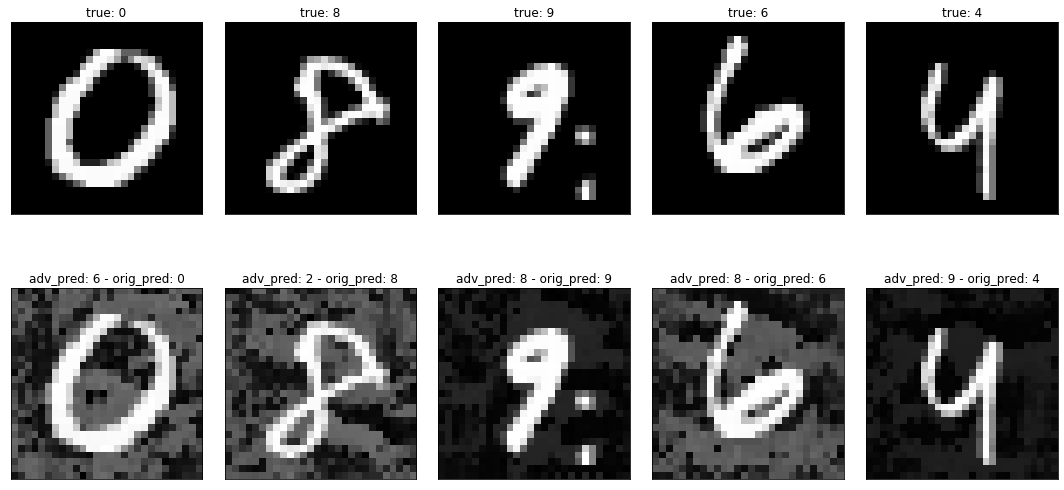

timestamp 2019-07-23 04.04.24.167937 attack cw_div2_attack layer:  relu3 regularization_weight:  100
batch [0] loss: 256.4861145019531
batch [100] loss: 165.2918701171875
batch [200] loss: 84.72470092773438
batch [300] loss: 32.03817367553711
batch [400] loss: 8.600350379943848
batch [500] loss: 2.0728607177734375
batch [600] loss: 0.3621937036514282
batch [700] loss: -9.536738798487931e-05
batch [800] loss: -9.536738798487931e-05
batch [900] loss: -9.536738798487931e-05
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


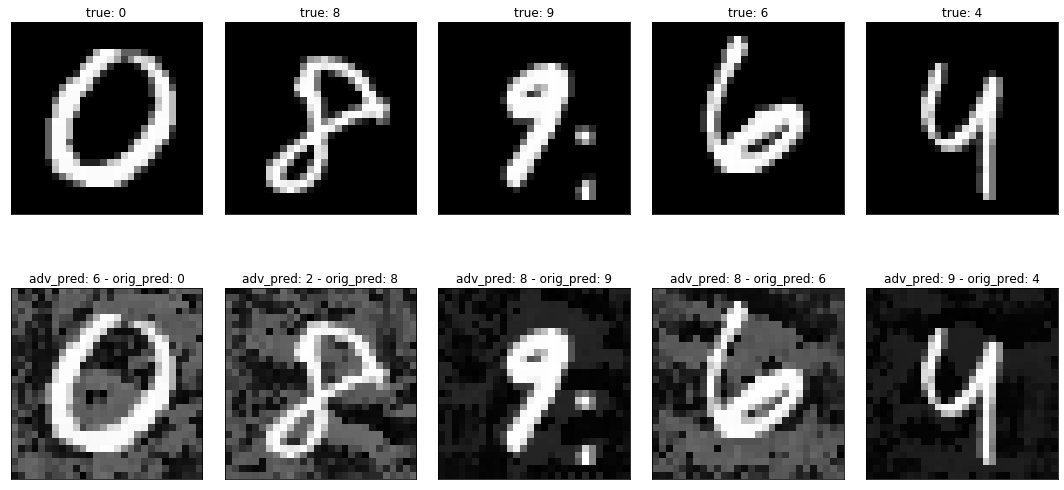

timestamp 2019-07-23 04.08.29.832556 attack cw_div3_attack layer:  relu1 regularization_weight:  0
batch [0] loss: -0.2874573767185211
batch [100] loss: -0.5519942045211792
batch [200] loss: -1.208559513092041
batch [300] loss: -2.3390111923217773
batch [400] loss: -3.589919328689575
batch [500] loss: -4.722370624542236
batch [600] loss: -5.712626934051514
batch [700] loss: -6.614236354827881
batch [800] loss: -7.454575061798096
batch [900] loss: -8.25178337097168
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


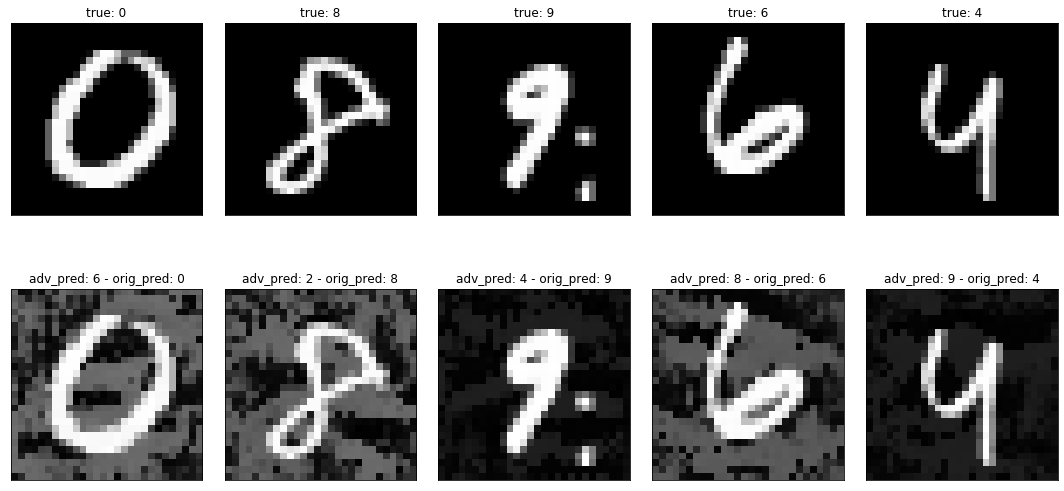

timestamp 2019-07-23 04.12.39.192324 attack cw_div3_attack layer:  relu1 regularization_weight:  0.001
batch [0] loss: -0.28698861598968506
batch [100] loss: -0.5515590906143188
batch [200] loss: -1.2081241607666016
batch [300] loss: -2.3385679721832275
batch [400] loss: -3.5897459983825684
batch [500] loss: -4.722092628479004
batch [600] loss: -5.7125654220581055
batch [700] loss: -6.614256381988525
batch [800] loss: -7.454641819000244
batch [900] loss: -8.252564430236816
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


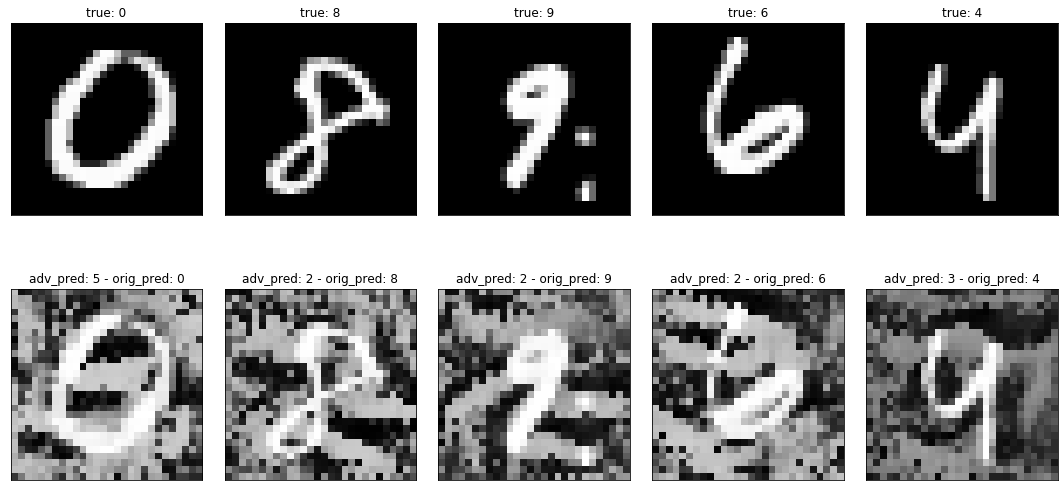

timestamp 2019-07-23 04.17.07.633924 attack cw_div3_attack layer:  relu1 regularization_weight:  0.01
batch [0] loss: -0.2827698588371277
batch [100] loss: -0.5479382276535034
batch [200] loss: -1.2039533853530884
batch [300] loss: -2.333486318588257
batch [400] loss: -3.5848116874694824
batch [500] loss: -4.717364311218262
batch [600] loss: -5.707235336303711
batch [700] loss: -6.609050750732422
batch [800] loss: -7.449493885040283
batch [900] loss: -8.24671459197998
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


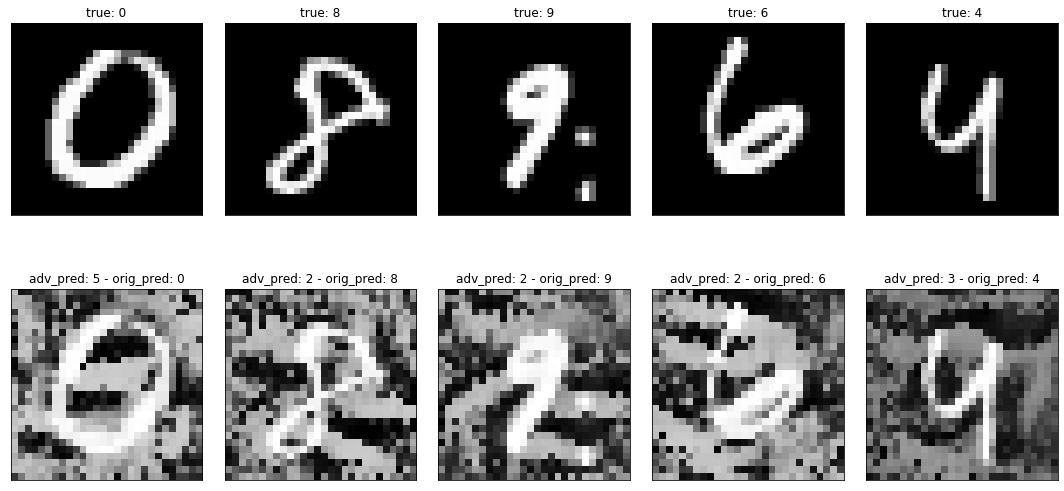

timestamp 2019-07-23 04.21.34.692970 attack cw_div3_attack layer:  relu1 regularization_weight:  1
batch [0] loss: 0.18129494786262512
batch [100] loss: -0.22855371236801147
batch [200] loss: -0.9684714078903198
batch [300] loss: -2.142578125
batch [400] loss: -3.420549154281616
batch [500] loss: -4.569984436035156
batch [600] loss: -5.572774410247803
batch [700] loss: -6.4841413497924805
batch [800] loss: -7.332589626312256
batch [900] loss: -8.13640022277832
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


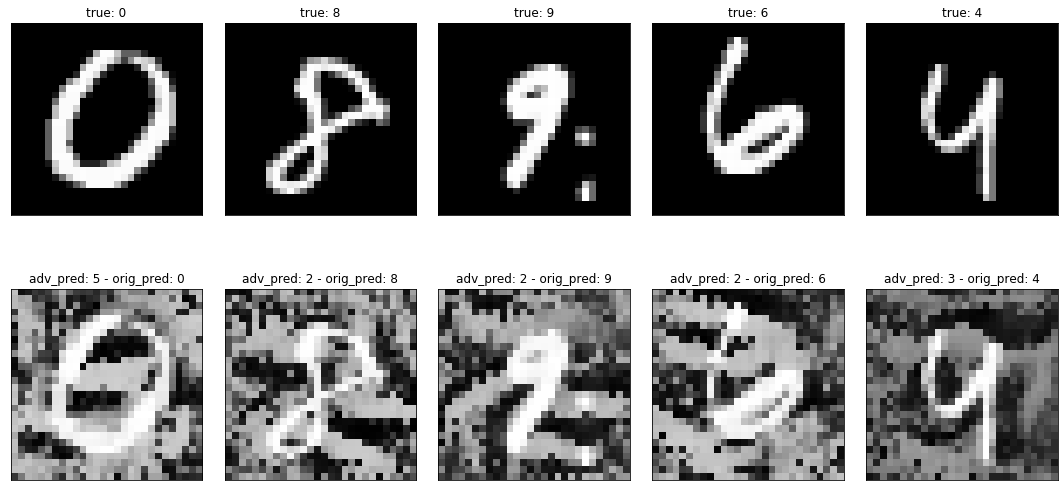

timestamp 2019-07-23 04.26.02.429662 attack cw_div3_attack layer:  relu1 regularization_weight:  10
batch [0] loss: 4.400065898895264
batch [100] loss: 2.657907724380493
batch [200] loss: 1.1074576377868652
batch [300] loss: -0.5553892850875854
batch [400] loss: -2.170564651489258
batch [500] loss: -3.557450771331787
batch [600] loss: -4.737445831298828
batch [700] loss: -5.7863311767578125
batch [800] loss: -6.742587089538574
batch [900] loss: -7.633108615875244
Perturbed Accuracy: 1/100 (1%)
Original Accuracy: 98/100 (98%)


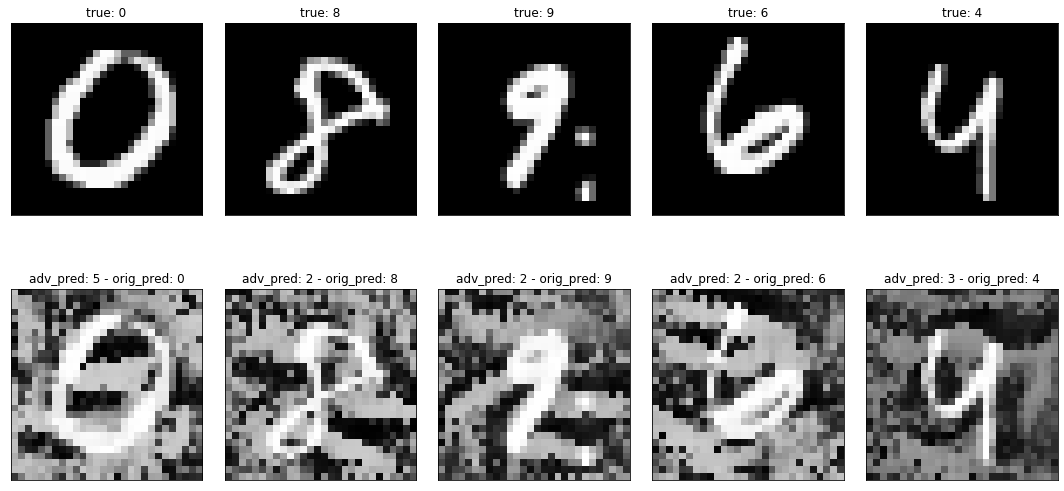

timestamp 2019-07-23 04.30.28.769220 attack cw_div3_attack layer:  relu1 regularization_weight:  100
batch [0] loss: 46.58777618408203
batch [100] loss: 31.522214889526367
batch [200] loss: 21.862106323242188
batch [300] loss: 15.306670188903809
batch [400] loss: 10.312289237976074
batch [500] loss: 6.540579795837402
batch [600] loss: 3.5750184059143066
batch [700] loss: 1.1341056823730469
batch [800] loss: -0.9222383499145508
batch [900] loss: -2.701620578765869
Perturbed Accuracy: 1/100 (1%)
Original Accuracy: 98/100 (98%)


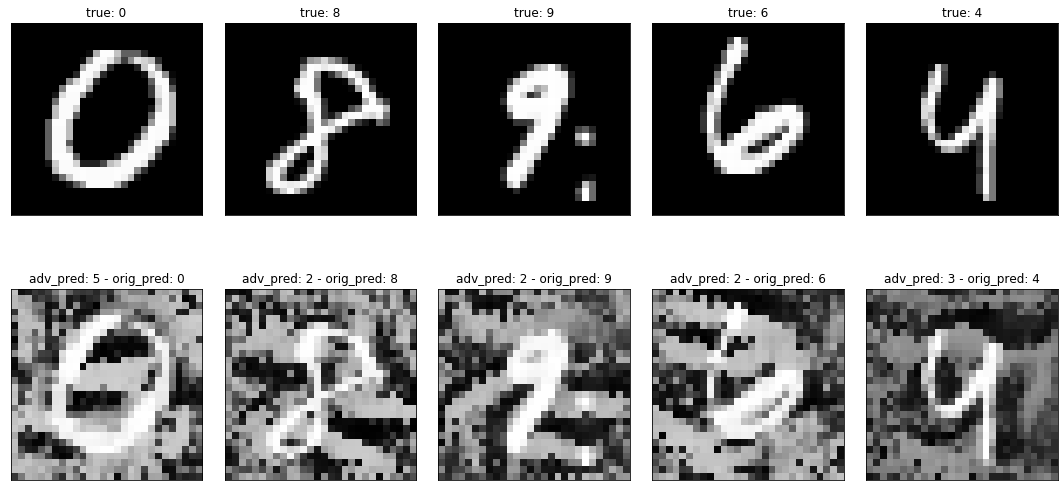

timestamp 2019-07-23 04.34.53.771908 attack cw_div3_attack layer:  relu2 regularization_weight:  0
batch [0] loss: -0.2874573767185211
batch [100] loss: -0.5519943237304688
batch [200] loss: -1.2085576057434082
batch [300] loss: -2.3390092849731445
batch [400] loss: -3.589895725250244
batch [500] loss: -4.722357273101807
batch [600] loss: -5.7127685546875
batch [700] loss: -6.6143646240234375
batch [800] loss: -7.4546966552734375
batch [900] loss: -8.2518949508667
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


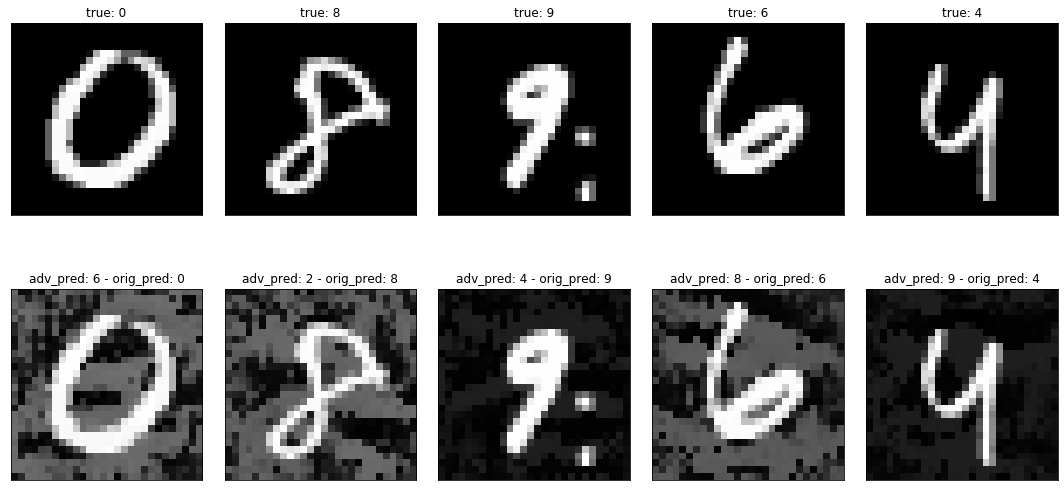

timestamp 2019-07-23 04.39.01.760602 attack cw_div3_attack layer:  relu2 regularization_weight:  0.001
batch [0] loss: -0.28739553689956665
batch [100] loss: -0.5519391298294067
batch [200] loss: -1.208486795425415
batch [300] loss: -2.3387703895568848
batch [400] loss: -3.589848279953003
batch [500] loss: -4.7223358154296875
batch [600] loss: -5.7126145362854
batch [700] loss: -6.614301681518555
batch [800] loss: -7.454533576965332
batch [900] loss: -8.251860618591309
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


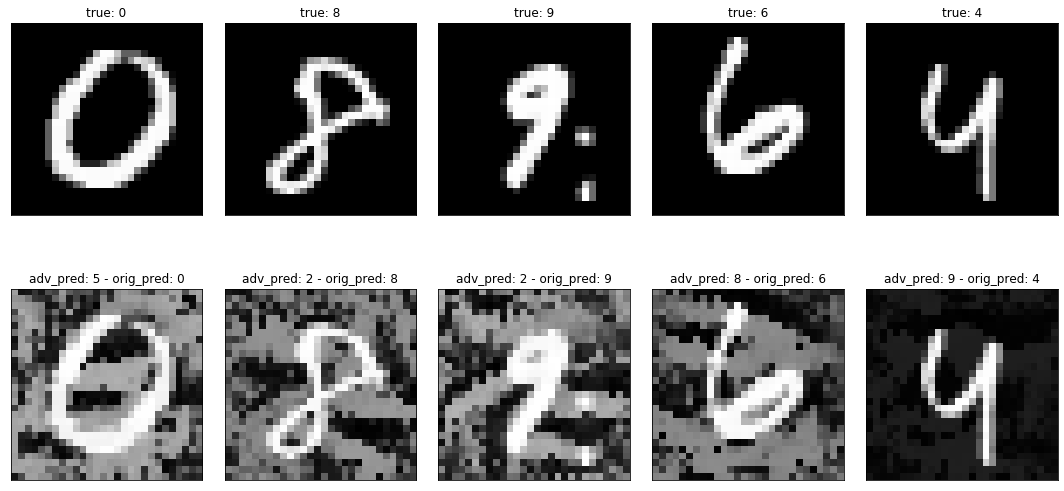

timestamp 2019-07-23 04.43.22.201353 attack cw_div3_attack layer:  relu2 regularization_weight:  0.01
batch [0] loss: -0.28683897852897644
batch [100] loss: -0.5514114499092102
batch [200] loss: -1.2081317901611328
batch [300] loss: -2.3382444381713867
batch [400] loss: -3.589794874191284
batch [500] loss: -4.7220635414123535
batch [600] loss: -5.712150573730469
batch [700] loss: -6.614046096801758
batch [800] loss: -7.454894065856934
batch [900] loss: -8.25232982635498
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


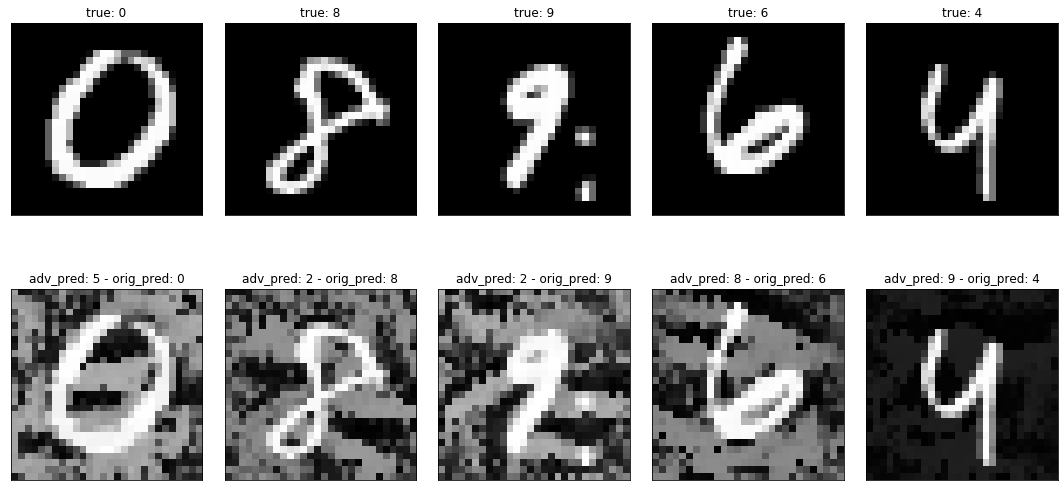

timestamp 2019-07-23 04.47.42.678095 attack cw_div3_attack layer:  relu2 regularization_weight:  1
batch [0] loss: -0.22561749815940857
batch [100] loss: -0.5033966898918152
batch [200] loss: -1.1663328409194946
batch [300] loss: -2.2971551418304443
batch [400] loss: -3.547785758972168
batch [500] loss: -4.680556774139404
batch [600] loss: -5.671899795532227
batch [700] loss: -6.574409008026123
batch [800] loss: -7.415709018707275
batch [900] loss: -8.21434497833252
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


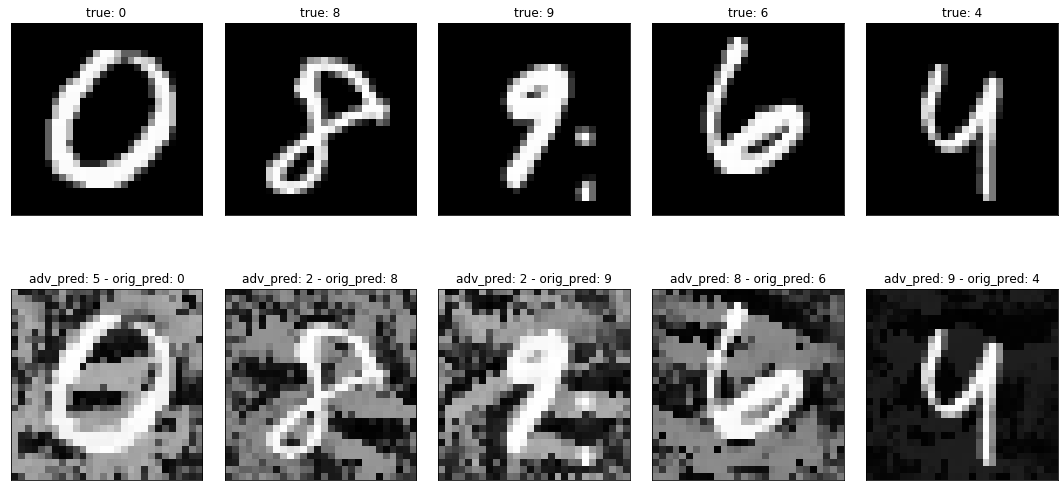

timestamp 2019-07-23 04.52.12.280156 attack cw_div3_attack layer:  relu2 regularization_weight:  10
batch [0] loss: 0.33094146847724915
batch [100] loss: -0.08931609988212585
batch [200] loss: -0.8604390621185303
batch [300] loss: -2.0679051876068115
batch [400] loss: -3.3674681186676025
batch [500] loss: -4.532952308654785
batch [600] loss: -5.547919273376465
batch [700] loss: -6.466167449951172
batch [800] loss: -7.318244457244873
batch [900] loss: -8.12398624420166
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


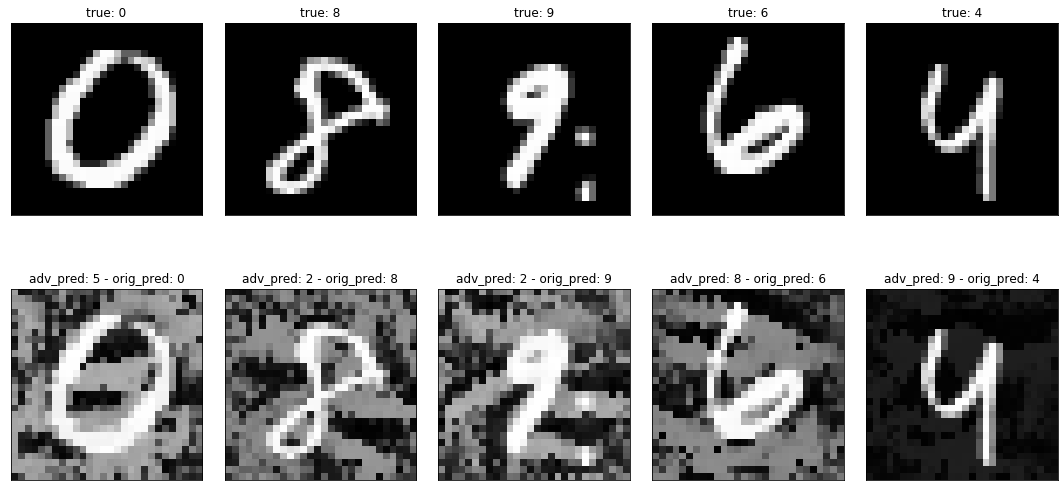

timestamp 2019-07-23 04.56.34.731989 attack cw_div3_attack layer:  relu2 regularization_weight:  100
batch [0] loss: 5.896530628204346
batch [100] loss: 4.0458574295043945
batch [200] loss: 2.1770012378692627
batch [300] loss: 0.17352652549743652
batch [400] loss: -1.6738930940628052
batch [500] loss: -3.233938694000244
batch [600] loss: -4.538363933563232
batch [700] loss: -5.660531520843506
batch [800] loss: -6.6629462242126465
batch [900] loss: -7.579900741577148
Perturbed Accuracy: 1/100 (1%)
Original Accuracy: 98/100 (98%)


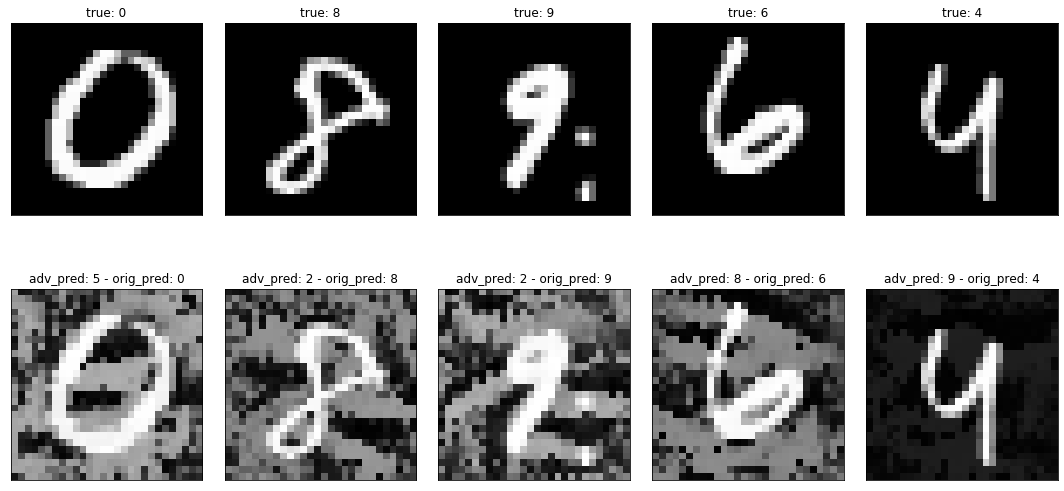

timestamp 2019-07-23 05.00.55.753436 attack cw_div3_attack layer:  relu3 regularization_weight:  0
batch [0] loss: -0.2874573767185211
batch [100] loss: -0.5519943237304688
batch [200] loss: -1.2085597515106201
batch [300] loss: -2.3390190601348877
batch [400] loss: -3.5899572372436523
batch [500] loss: -4.7223591804504395
batch [600] loss: -5.7127814292907715
batch [700] loss: -6.614407539367676
batch [800] loss: -7.454522609710693
batch [900] loss: -8.251801490783691
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


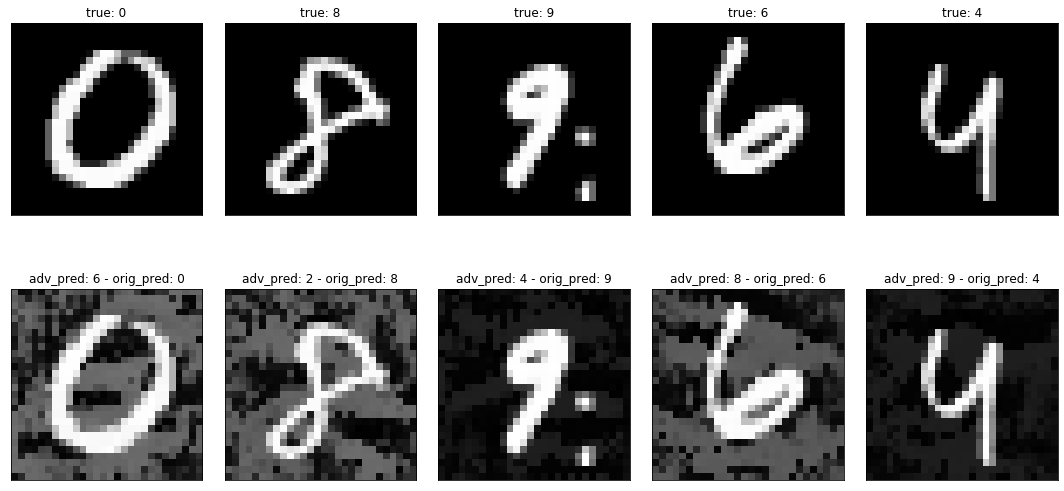

timestamp 2019-07-23 05.05.03.873328 attack cw_div3_attack layer:  relu3 regularization_weight:  0.001
batch [0] loss: -0.2874573767185211
batch [100] loss: -0.5519943833351135
batch [200] loss: -1.2085586786270142
batch [300] loss: -2.339012861251831
batch [400] loss: -3.589916944503784
batch [500] loss: -4.722325325012207
batch [600] loss: -5.712726593017578
batch [700] loss: -6.614389419555664
batch [800] loss: -7.454570770263672
batch [900] loss: -8.25170612335205
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


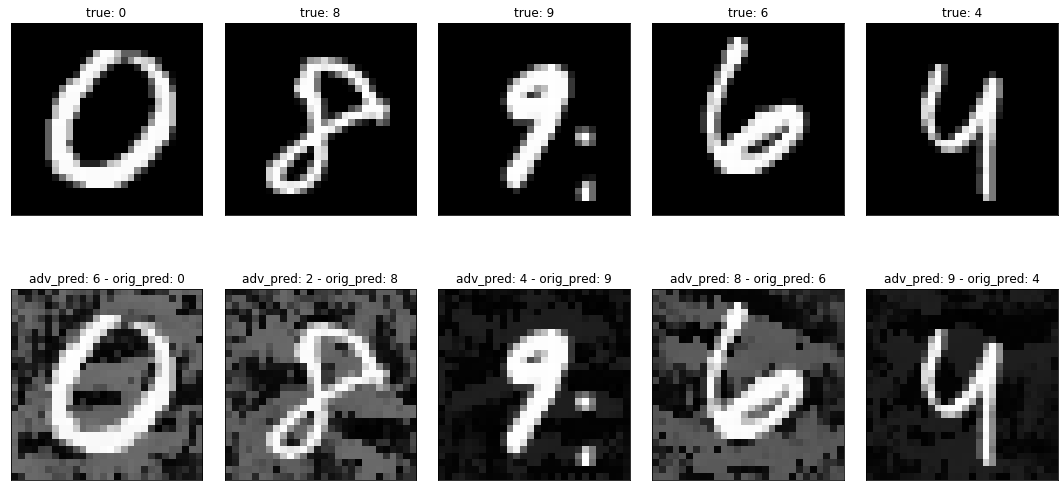

timestamp 2019-07-23 05.09.11.249236 attack cw_div3_attack layer:  relu3 regularization_weight:  0.01
batch [0] loss: -0.2874573767185211
batch [100] loss: -0.5519943833351135
batch [200] loss: -1.2085578441619873
batch [300] loss: -2.338996648788452
batch [400] loss: -3.5898916721343994
batch [500] loss: -4.722342491149902
batch [600] loss: -5.712759017944336
batch [700] loss: -6.614458084106445
batch [800] loss: -7.454716205596924
batch [900] loss: -8.252043724060059
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


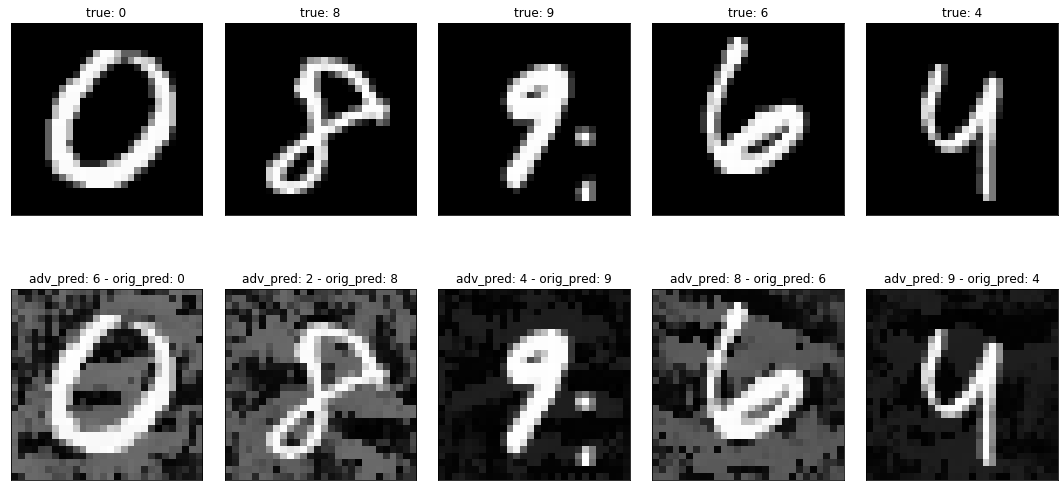

timestamp 2019-07-23 05.13.18.381859 attack cw_div3_attack layer:  relu3 regularization_weight:  1
batch [0] loss: -0.2874583303928375
batch [100] loss: -0.5519954562187195
batch [200] loss: -1.2085591554641724
batch [300] loss: -2.339002847671509
batch [400] loss: -3.5899012088775635
batch [500] loss: -4.722364902496338
batch [600] loss: -5.712760925292969
batch [700] loss: -6.614450454711914
batch [800] loss: -7.4545979499816895
batch [900] loss: -8.251771926879883
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


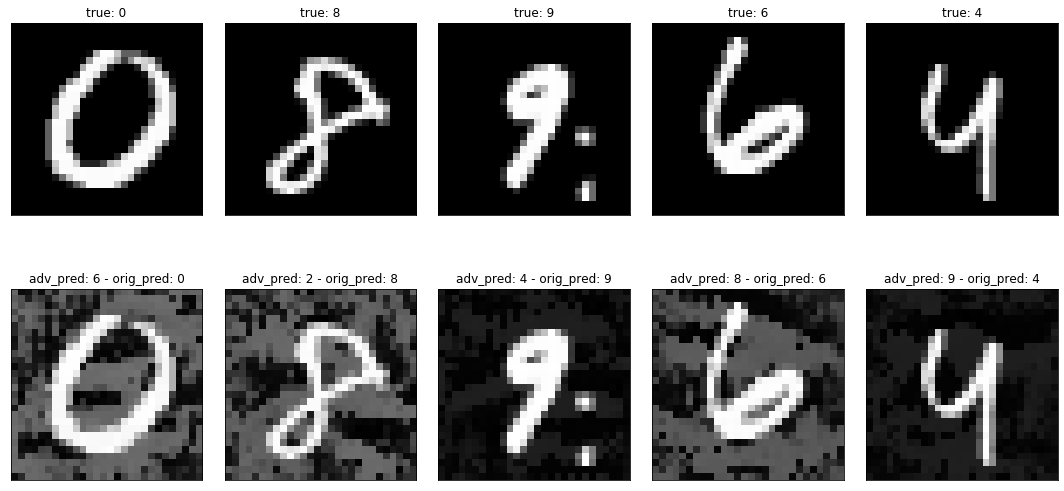

timestamp 2019-07-23 05.17.25.052758 attack cw_div3_attack layer:  relu3 regularization_weight:  10
batch [0] loss: -0.2874669134616852
batch [100] loss: -0.5520042181015015
batch [200] loss: -1.2085673809051514
batch [300] loss: -2.3390052318573
batch [400] loss: -3.5898687839508057
batch [500] loss: -4.7223286628723145
batch [600] loss: -5.712618350982666
batch [700] loss: -6.614209175109863
batch [800] loss: -7.4543938636779785
batch [900] loss: -8.251566886901855
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


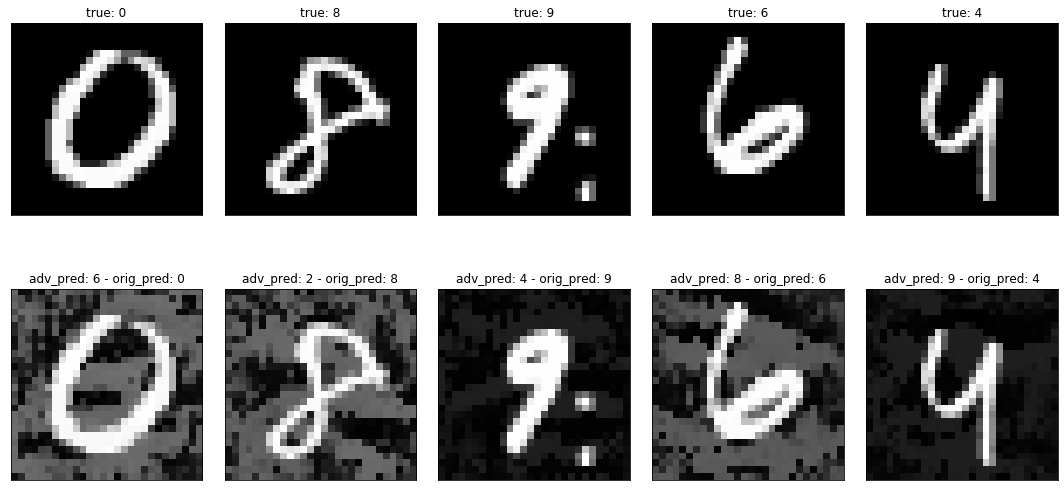

timestamp 2019-07-23 05.21.32.252731 attack cw_div3_attack layer:  relu3 regularization_weight:  100
batch [0] loss: -0.28755274415016174
batch [100] loss: -0.552089512348175
batch [200] loss: -1.2086520195007324
batch [300] loss: -2.339103937149048
batch [400] loss: -3.590003252029419
batch [500] loss: -4.722419261932373
batch [600] loss: -5.712768077850342
batch [700] loss: -6.614255905151367
batch [800] loss: -7.454519271850586
batch [900] loss: -8.25169849395752
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


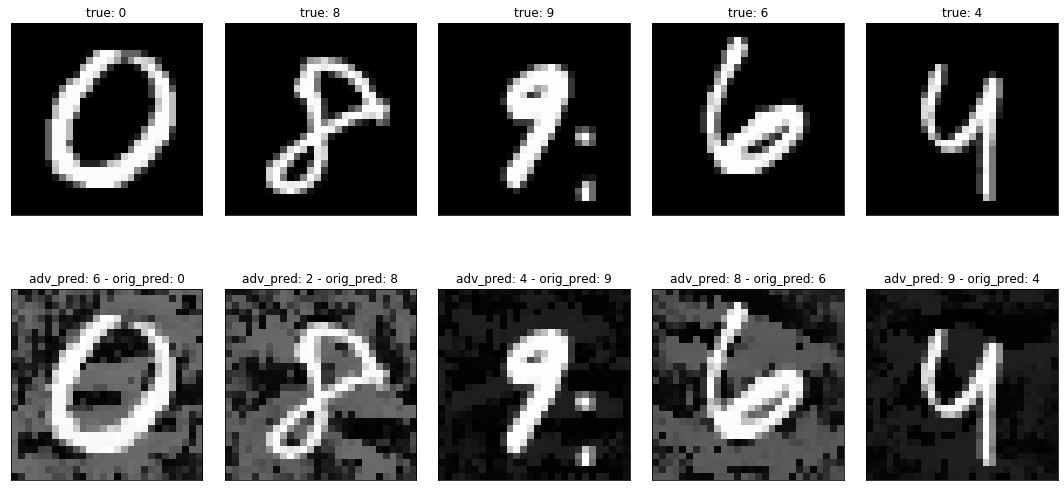

timestamp 2019-07-23 05.25.39.060402 attack cw_div4_attack layer:  relu1 regularization_weight:  0
Step 0
batch [0] loss: 0.2564862370491028
batch [100] loss: 0.16551198065280914
batch [200] loss: 0.08495761454105377
batch [300] loss: 0.032203856855630875
batch [400] loss: 0.008641590364277363
batch [500] loss: 0.0021077762357890606
batch [600] loss: 0.0003887151542585343
batch [700] loss: 0.0
Step 1
batch [0] loss: 0.0
Step 2
batch [0] loss: 0.0
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


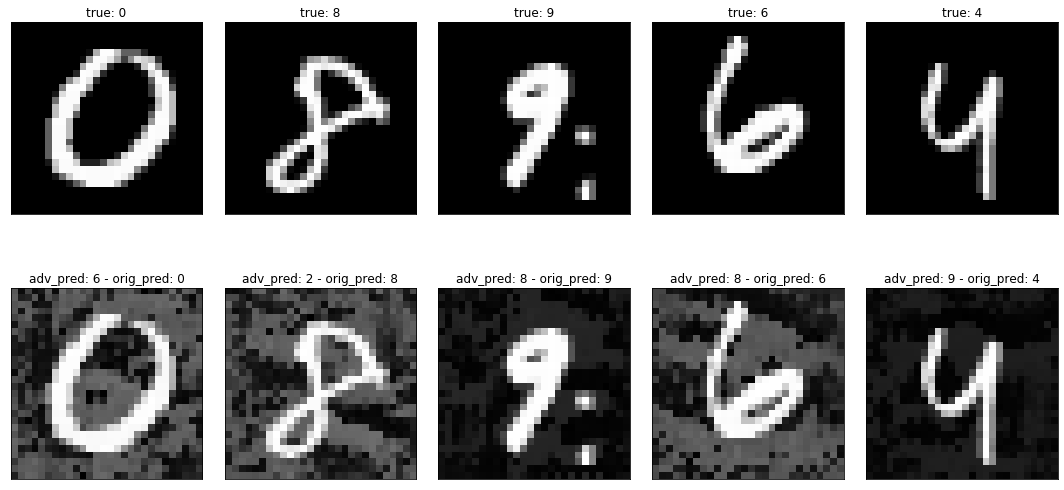

timestamp 2019-07-23 05.26.16.742090 attack cw_div4_attack layer:  relu1 regularization_weight:  0.001
Step 0
batch [0] loss: 0.25695499777793884
batch [100] loss: 0.1659543812274933
batch [200] loss: 0.08530906587839127
batch [300] loss: 0.03249059244990349
batch [400] loss: 0.008882075548171997
batch [500] loss: 0.002315766643732786
batch [600] loss: 0.0005721676861867309
batch [700] loss: 0.00016325923206750304
batch [800] loss: 0.0001471873838454485
batch [900] loss: 0.00013395452697295696
Step 1
batch [0] loss: 0.00012290599988773465
batch [100] loss: 0.00011336857278365642
batch [200] loss: 0.00010505405225558206
batch [300] loss: 9.775906073627993e-05
batch [400] loss: 9.124313510255888e-05
batch [500] loss: 8.540111593902111e-05
batch [600] loss: 8.014776540221646e-05
batch [700] loss: 7.538263162132353e-05
batch [800] loss: 7.100838411133736e-05
batch [900] loss: 6.700817175442353e-05
Step 2
batch [0] loss: 6.333895726129413e-05
batch [100] loss: 5.994530511088669e-05
batch [2

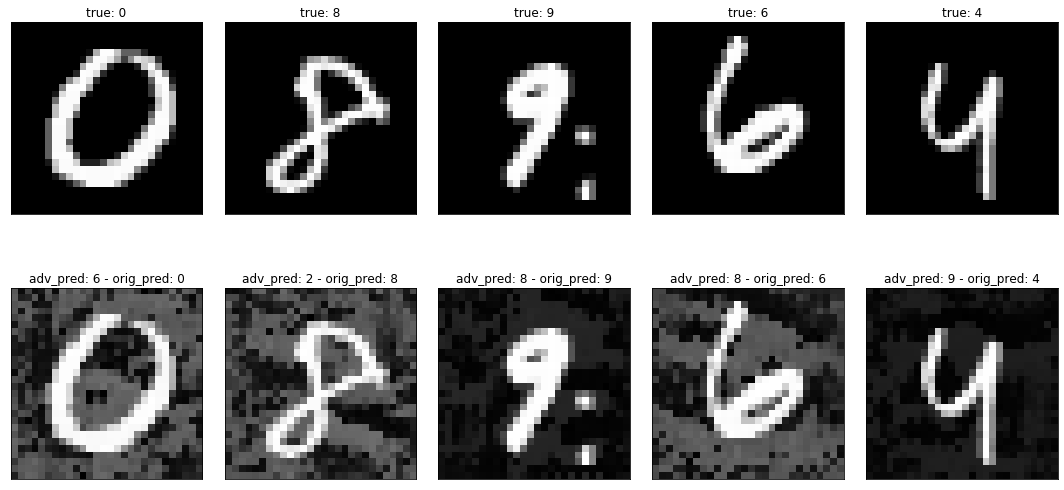

timestamp 2019-07-23 05.29.28.311717 attack cw_div4_attack layer:  relu1 regularization_weight:  0.01
Step 0
batch [0] loss: 0.2611737549304962
batch [100] loss: 0.16906407475471497
batch [200] loss: 0.0877438560128212
batch [300] loss: 0.03414001315832138
batch [400] loss: 0.010208017192780972
batch [500] loss: 0.0034163754899054766
batch [600] loss: 0.0015039771096780896
batch [700] loss: 0.0009631384746171534
batch [800] loss: 0.0008408207213506103
batch [900] loss: 0.0007397237350232899
Step 1
batch [0] loss: 0.0006547841476276517
batch [100] loss: 0.0005825514090247452
batch [200] loss: 0.0005207154899835587
batch [300] loss: 0.0004670190392062068
batch [400] loss: 0.00041997095104306936
batch [500] loss: 0.000378646538592875
batch [600] loss: 0.00034205723204649985
batch [700] loss: 0.00030954371322877705
batch [800] loss: 0.00028058351017534733
batch [900] loss: 0.0002544588060118258
Step 2
batch [0] loss: 0.0002308444381924346
batch [100] loss: 0.00020938360830768943
batch [200

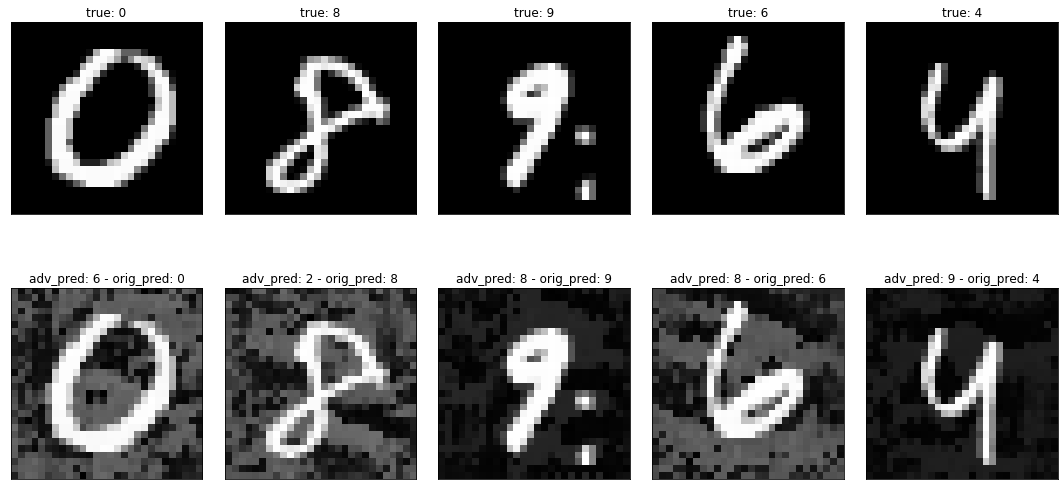

timestamp 2019-07-23 05.32.40.319732 attack cw_div4_attack layer:  relu1 regularization_weight:  1
Step 0
batch [0] loss: 0.725238561630249
batch [100] loss: 0.4870811104774475
batch [200] loss: 0.3169306218624115
batch [300] loss: 0.20955905318260193
batch [400] loss: 0.14828801155090332
batch [500] loss: 0.11516065150499344
batch [600] loss: 0.09351716935634613
batch [700] loss: 0.07755926251411438
batch [800] loss: 0.0651567280292511
batch [900] loss: 0.05513159930706024
Step 1
batch [0] loss: 0.04864147678017616
batch [100] loss: 0.03999647870659828
batch [200] loss: 0.03442538529634476
batch [300] loss: 0.029777267947793007
batch [400] loss: 0.025861315429210663
batch [500] loss: 0.0225214920938015
batch [600] loss: 0.01964821107685566
batch [700] loss: 0.01717236079275608
batch [800] loss: 0.015029498375952244
batch [900] loss: 0.013155197724699974
Step 2
batch [0] loss: 0.011485757306218147
batch [100] loss: 0.01000225730240345
batch [200] loss: 0.008688048459589481
batch [300] 

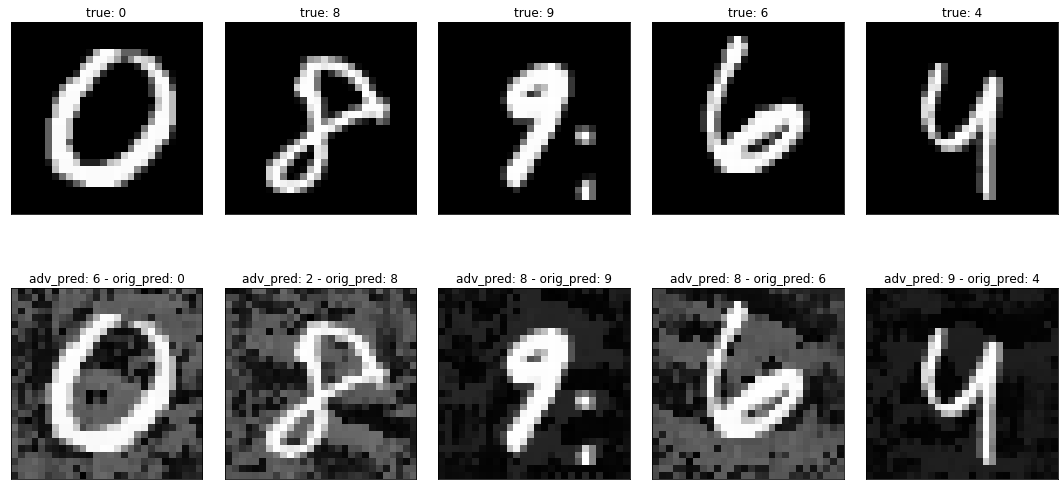

timestamp 2019-07-23 05.35.51.855426 attack cw_div4_attack layer:  relu1 regularization_weight:  10
Step 0
batch [0] loss: 4.944009780883789
batch [100] loss: 3.3734774589538574
batch [200] loss: 2.392542600631714
batch [300] loss: 1.795939564704895
batch [400] loss: 1.3967626094818115
batch [500] loss: 1.125174641609192
batch [600] loss: 0.9249336123466492
batch [700] loss: 0.7697854042053223
batch [800] loss: 0.647415280342102
batch [900] loss: 0.5485050082206726
Step 1
batch [0] loss: 0.4727667570114136
batch [100] loss: 0.403438925743103
batch [200] loss: 0.3454851508140564
batch [300] loss: 0.29654160141944885
batch [400] loss: 0.2565411925315857
batch [500] loss: 0.2228764295578003
batch [600] loss: 0.1941298246383667
batch [700] loss: 0.16954940557479858
batch [800] loss: 0.14823266863822937
batch [900] loss: 0.12962216138839722
Step 2
batch [0] loss: 0.11316365748643875
batch [100] loss: 0.09850915521383286
batch [200] loss: 0.08548427373170853
batch [300] loss: 0.0738478526473

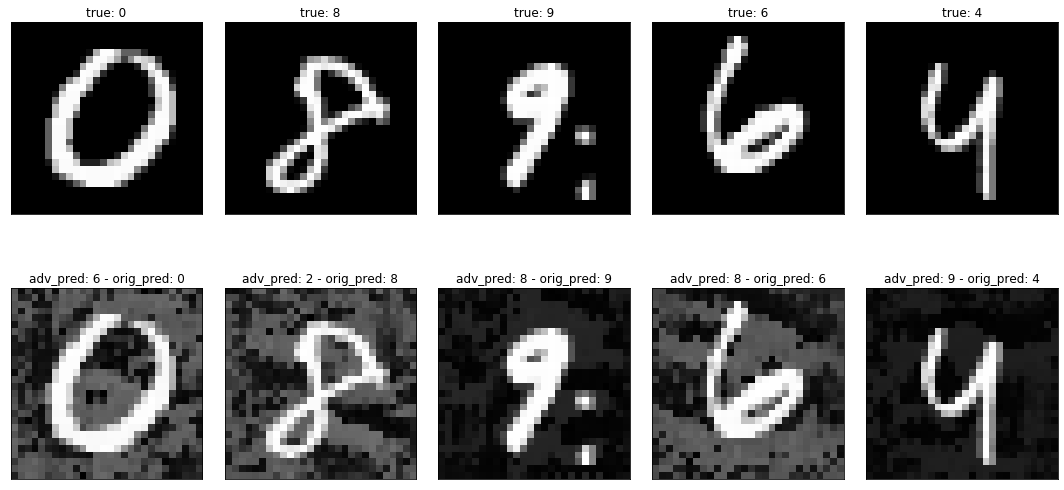

timestamp 2019-07-23 05.39.02.759070 attack cw_div4_attack layer:  relu1 regularization_weight:  100
Step 0
batch [0] loss: 47.131717681884766
batch [100] loss: 32.237796783447266
batch [200] loss: 23.147172927856445
batch [300] loss: 17.65799331665039
batch [400] loss: 13.879493713378906
batch [500] loss: 11.223151206970215
batch [600] loss: 9.237184524536133
batch [700] loss: 7.689971923828125
batch [800] loss: 6.467451095581055
batch [900] loss: 5.479483604431152
Step 1
batch [0] loss: 4.674656391143799
batch [100] loss: 4.002279758453369
batch [200] loss: 3.4436938762664795
batch [300] loss: 2.9746627807617188
batch [400] loss: 2.5784912109375
batch [500] loss: 2.239647388458252
batch [600] loss: 1.9497201442718506
batch [700] loss: 1.7019602060317993
batch [800] loss: 1.4875632524490356
batch [900] loss: 1.3008191585540771
Step 2
batch [0] loss: 1.1353235244750977
batch [100] loss: 0.9892051815986633
batch [200] loss: 0.8582059144973755
batch [300] loss: 0.7413286566734314
batch [

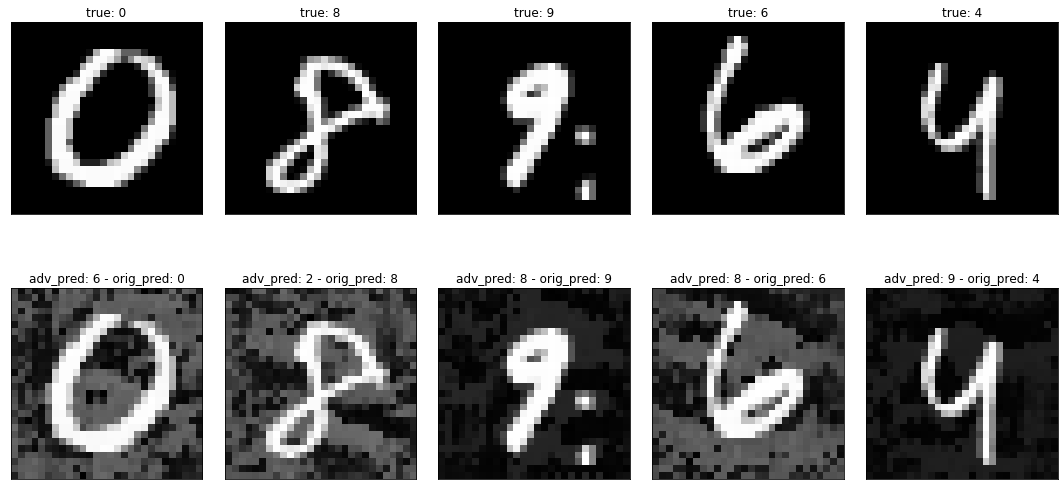

timestamp 2019-07-23 05.42.14.201204 attack cw_div4_attack layer:  relu2 regularization_weight:  0
Step 0
batch [0] loss: 0.2564862370491028
batch [100] loss: 0.16551224887371063
batch [200] loss: 0.0849573016166687
batch [300] loss: 0.03220399096608162
batch [400] loss: 0.008641806431114674
batch [500] loss: 0.002107726177200675
batch [600] loss: 0.000388737564207986
batch [700] loss: 0.0
Step 1
batch [0] loss: 0.0
Step 2
batch [0] loss: 0.0
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


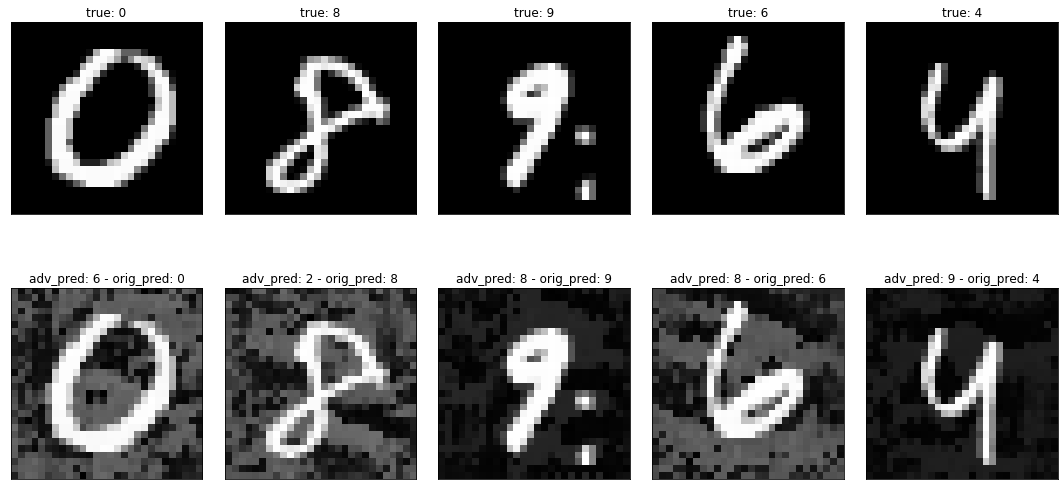

timestamp 2019-07-23 05.42.52.162937 attack cw_div4_attack layer:  relu2 regularization_weight:  0.001
Step 0
batch [0] loss: 0.25654807686805725
batch [100] loss: 0.16556596755981445
batch [200] loss: 0.08500780165195465
batch [300] loss: 0.03225390985608101
batch [400] loss: 0.008689489215612411
batch [500] loss: 0.002153973560780287
batch [600] loss: 0.00043344462756067514
batch [700] loss: 4.307887866161764e-05
batch [800] loss: 4.1545550629962236e-05
batch [900] loss: 4.011709461337887e-05
Step 1
batch [0] loss: 3.870971704600379e-05
batch [100] loss: 3.72885333490558e-05
batch [200] loss: 3.5836928873322904e-05
batch [300] loss: 3.441785884206183e-05
batch [400] loss: 3.304164783912711e-05
batch [500] loss: 3.168638431816362e-05
batch [600] loss: 3.030676452908665e-05
batch [700] loss: 2.8953772925888188e-05
batch [800] loss: 2.7661417334456928e-05
batch [900] loss: 2.6401814466225915e-05
Step 2
batch [0] loss: 2.5195349735440686e-05
batch [100] loss: 2.406875864835456e-05
batch 

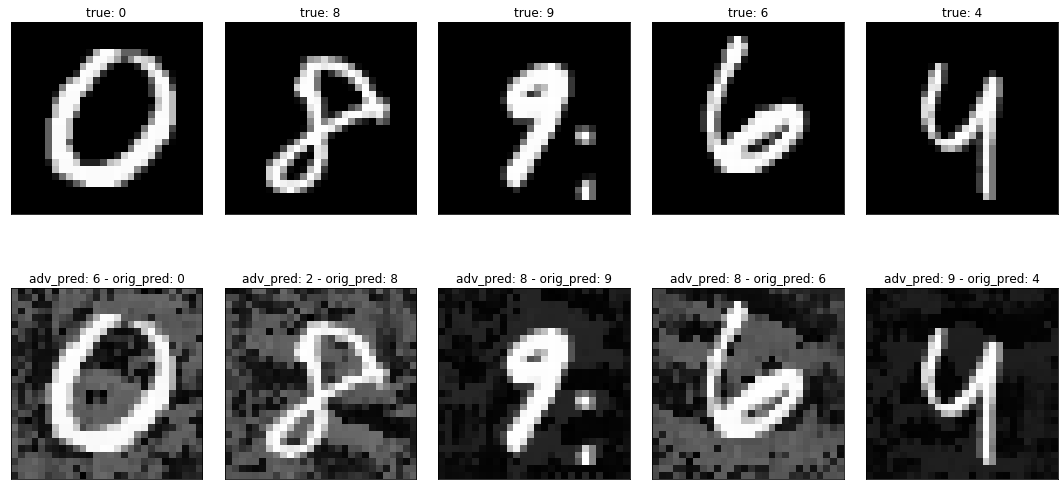

timestamp 2019-07-23 05.46.06.457437 attack cw_div4_attack layer:  relu2 regularization_weight:  0.01
Step 0
batch [0] loss: 0.25710463523864746
batch [100] loss: 0.16606906056404114
batch [200] loss: 0.08541468530893326
batch [300] loss: 0.03260288015007973
batch [400] loss: 0.008992832154035568
batch [500] loss: 0.0024176533333957195
batch [600] loss: 0.0006631988799199462
batch [700] loss: 0.00024345092242583632
batch [800] loss: 0.00021641190687660128
batch [900] loss: 0.00019256400992162526
Step 1
batch [0] loss: 0.0001708496711216867
batch [100] loss: 0.0001514892210252583
batch [200] loss: 0.00013404469063971192
batch [300] loss: 0.00011926315346499905
batch [400] loss: 0.00010670565097825602
batch [500] loss: 9.603492799215019e-05
batch [600] loss: 8.672818512422964e-05
batch [700] loss: 7.868934335419908e-05
batch [800] loss: 7.157247455324978e-05
batch [900] loss: 6.527662480948493e-05
Step 2
batch [0] loss: 5.9814934502355754e-05
batch [100] loss: 5.499031249200925e-05
batch

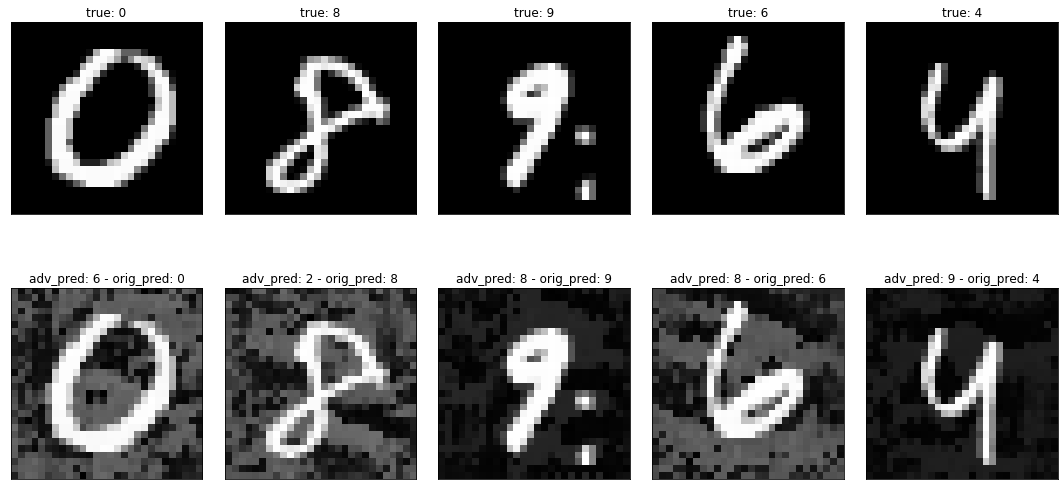

timestamp 2019-07-23 05.49.21.165761 attack cw_div4_attack layer:  relu2 regularization_weight:  1
Step 0
batch [0] loss: 0.31832611560821533
batch [100] loss: 0.2123035490512848
batch [200] loss: 0.11997060477733612
batch [300] loss: 0.058136727660894394
batch [400] loss: 0.028479112312197685
batch [500] loss: 0.01736096292734146
batch [600] loss: 0.012157309800386429
batch [700] loss: 0.009492006152868271
batch [800] loss: 0.00771636888384819
batch [900] loss: 0.00638497993350029
Step 1
batch [0] loss: 0.005272384732961655
batch [100] loss: 0.004421945661306381
batch [200] loss: 0.0037700943648815155
batch [300] loss: 0.003252517431974411
batch [400] loss: 0.0028079189360141754
batch [500] loss: 0.0024309083819389343
batch [600] loss: 0.002082172781229019
batch [700] loss: 0.0017794966697692871
batch [800] loss: 0.0015169605612754822
batch [900] loss: 0.0012995898723602295
Step 2
batch [0] loss: 0.0011164546012878418
batch [100] loss: 0.0009592324495315552
batch [200] loss: 0.0008282

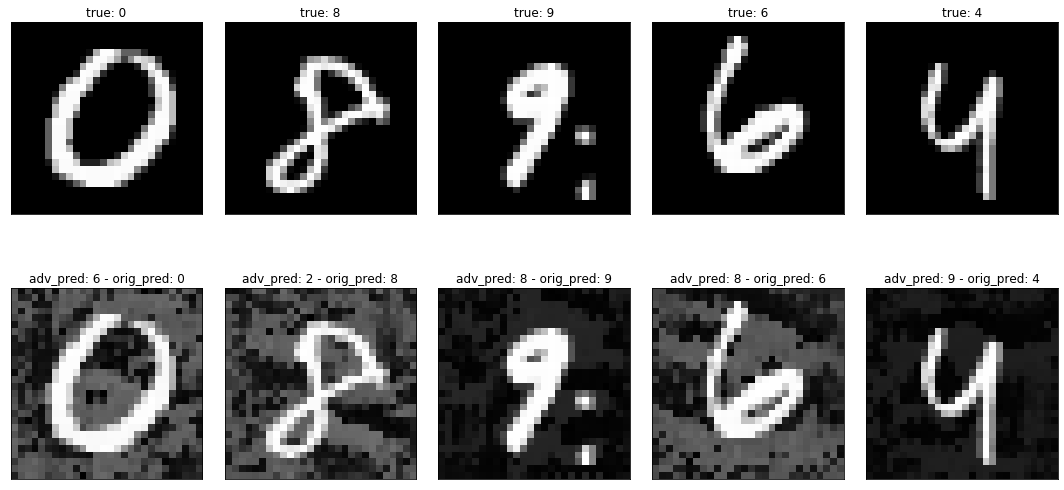

timestamp 2019-07-23 05.52.36.135969 attack cw_div4_attack layer:  relu2 regularization_weight:  10
Step 0
batch [0] loss: 0.874885082244873
batch [100] loss: 0.6260133981704712
batch [200] loss: 0.42474889755249023
batch [300] loss: 0.28332871198654175
batch [400] loss: 0.19907665252685547
batch [500] loss: 0.148428812623024
batch [600] loss: 0.11435068398714066
batch [700] loss: 0.0908709242939949
batch [800] loss: 0.07379555702209473
batch [900] loss: 0.06103654205799103
Step 1
batch [0] loss: 0.05254288390278816
batch [100] loss: 0.0431915745139122
batch [200] loss: 0.036830827593803406
batch [300] loss: 0.031405314803123474
batch [400] loss: 0.02696022391319275
batch [500] loss: 0.02328440546989441
batch [600] loss: 0.019965358078479767
batch [700] loss: 0.017123892903327942
batch [800] loss: 0.014651045203208923
batch [900] loss: 0.012536048889160156
Step 2
batch [0] loss: 0.01074083149433136
batch [100] loss: 0.00919923186302185
batch [200] loss: 0.007858648896217346
batch [300]

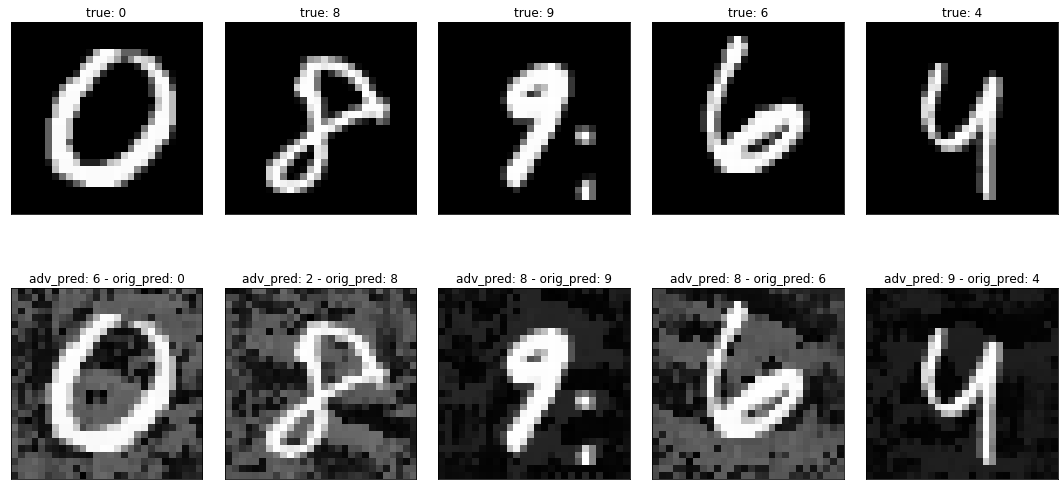

timestamp 2019-07-23 05.55.50.349034 attack cw_div4_attack layer:  relu2 regularization_weight:  100
Step 0
batch [0] loss: 6.440474510192871
batch [100] loss: 4.7607550621032715
batch [200] loss: 3.46130633354187
batch [300] loss: 2.524582862854004
batch [400] loss: 1.8921666145324707
batch [500] loss: 1.4488120079040527
batch [600] loss: 1.1253987550735474
batch [700] loss: 0.8972337245941162
batch [800] loss: 0.7289946675300598
batch [900] loss: 0.603874683380127
Step 1
batch [0] loss: 0.5139422416687012
batch [100] loss: 0.43768227100372314
batch [200] loss: 0.37491992115974426
batch [300] loss: 0.3189224600791931
batch [400] loss: 0.27258098125457764
batch [500] loss: 0.23278743028640747
batch [600] loss: 0.20004808902740479
batch [700] loss: 0.1724429428577423
batch [800] loss: 0.1476496458053589
batch [900] loss: 0.12610480189323425
Step 2
batch [0] loss: 0.10743364691734314
batch [100] loss: 0.09149610996246338
batch [200] loss: 0.07750764489173889
batch [300] loss: 0.065242499

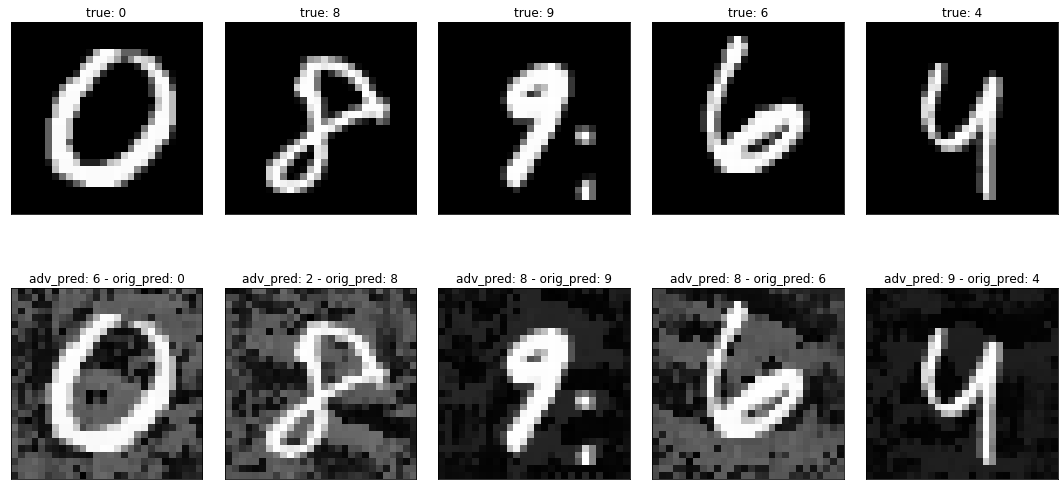

timestamp 2019-07-23 05.59.04.742377 attack cw_div4_attack layer:  relu3 regularization_weight:  0
Step 0
batch [0] loss: 0.2564862370491028
batch [100] loss: 0.16551202535629272
batch [200] loss: 0.0849580317735672
batch [300] loss: 0.03220369294285774
batch [400] loss: 0.008641944266855717
batch [500] loss: 0.0021079143043607473
batch [600] loss: 0.00038879216299392283
batch [700] loss: 0.0
Step 1
batch [0] loss: 0.0
Step 2
batch [0] loss: 0.0
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 98/100 (98%)


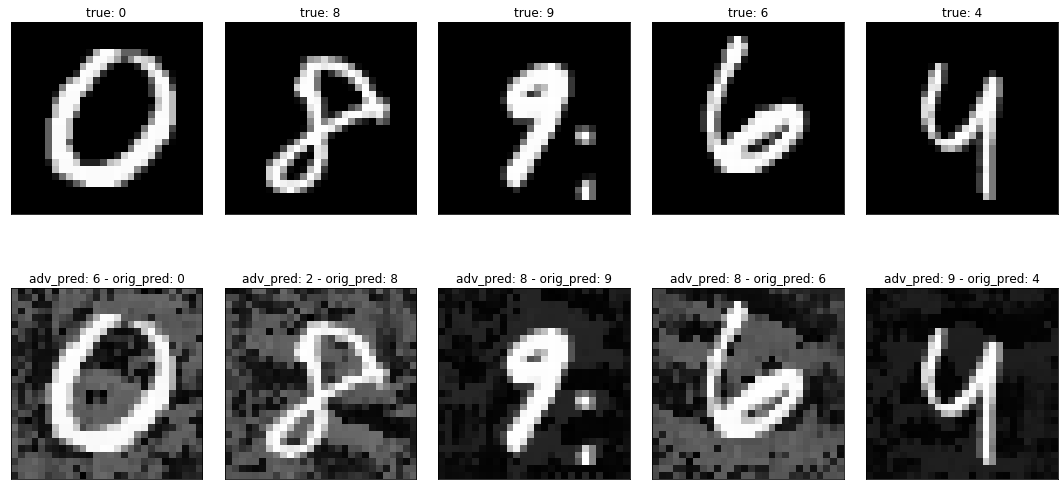

timestamp 2019-07-23 05.59.42.789627 attack cw_div4_attack layer:  relu3 regularization_weight:  0.001
Step 0
batch [0] loss: 0.2564862370491028
batch [100] loss: 0.16551199555397034
batch [200] loss: 0.08495762944221497
batch [300] loss: 0.032204024493694305
batch [400] loss: 0.008641840890049934
batch [500] loss: 0.002107689855620265
batch [600] loss: 0.0003887136117555201
batch [700] loss: -9.536739176141396e-10
batch [800] loss: -9.536739176141396e-10
batch [900] loss: -9.536739176141396e-10
Step 1
batch [0] loss: -9.536739176141396e-10
batch [100] loss: -9.536739176141396e-10
batch [200] loss: -9.536739176141396e-10
batch [300] loss: -9.536739176141396e-10
batch [400] loss: -9.536739176141396e-10
batch [500] loss: -9.536739176141396e-10
batch [600] loss: -9.536739176141396e-10
batch [700] loss: -9.536739176141396e-10
batch [800] loss: -9.536739176141396e-10
batch [900] loss: -9.536739176141396e-10
Step 2
batch [0] loss: -9.536739176141396e-10
batch [100] loss: -9.536739176141396e-

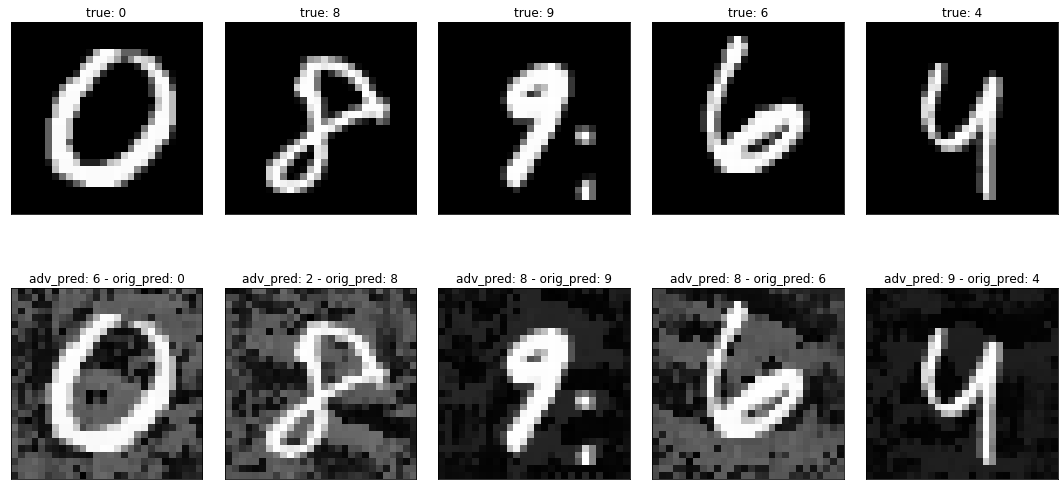

timestamp 2019-07-23 06.02.58.227583 attack cw_div4_attack layer:  relu3 regularization_weight:  0.01
Step 0
batch [0] loss: 0.2564862370491028
batch [100] loss: 0.16551201045513153
batch [200] loss: 0.08495793491601944
batch [300] loss: 0.03220394626259804
batch [400] loss: 0.008641931228339672
batch [500] loss: 0.0021078321151435375
batch [600] loss: 0.0003889362851623446
batch [700] loss: -9.53673851000758e-09
batch [800] loss: -9.53673851000758e-09
batch [900] loss: -9.53673851000758e-09
Step 1
batch [0] loss: -9.53673851000758e-09
batch [100] loss: -9.53673851000758e-09
batch [200] loss: -9.53673851000758e-09
batch [300] loss: -9.53673851000758e-09
batch [400] loss: -9.53673851000758e-09
batch [500] loss: -9.53673851000758e-09
batch [600] loss: -9.53673851000758e-09
batch [700] loss: -9.53673851000758e-09
batch [800] loss: -9.53673851000758e-09
batch [900] loss: -9.53673851000758e-09
Step 2
batch [0] loss: -9.53673851000758e-09
batch [100] loss: -9.53673851000758e-09
batch [200] l

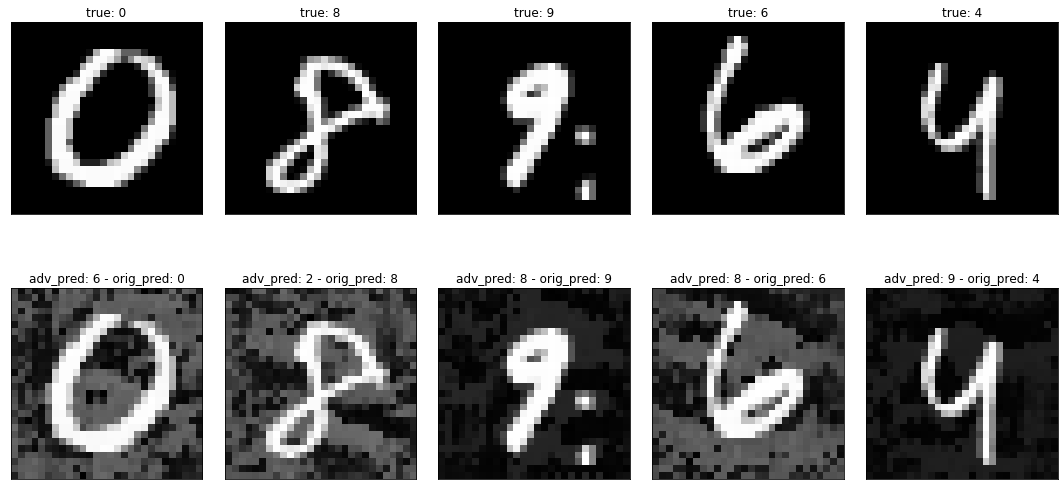

timestamp 2019-07-23 06.06.13.143779 attack cw_div4_attack layer:  relu3 regularization_weight:  1
Step 0
batch [0] loss: 0.2564852833747864
batch [100] loss: 0.1655111014842987
batch [200] loss: 0.08495751768350601
batch [300] loss: 0.03220316395163536
batch [400] loss: 0.008640619926154613
batch [500] loss: 0.0021067194174975157
batch [600] loss: 0.0003877320559695363
batch [700] loss: -9.536738616588991e-07
batch [800] loss: -9.536738616588991e-07
batch [900] loss: -9.536738616588991e-07
Step 1
batch [0] loss: -9.536738616588991e-07
batch [100] loss: -9.536738616588991e-07
batch [200] loss: -9.536738616588991e-07
batch [300] loss: -9.536738616588991e-07
batch [400] loss: -9.536738616588991e-07
batch [500] loss: -9.536738616588991e-07
batch [600] loss: -9.536738616588991e-07
batch [700] loss: -9.536738616588991e-07
batch [800] loss: -9.536738616588991e-07
batch [900] loss: -9.536738616588991e-07
Step 2
batch [0] loss: -9.536738616588991e-07
batch [100] loss: -9.536738616588991e-07
ba

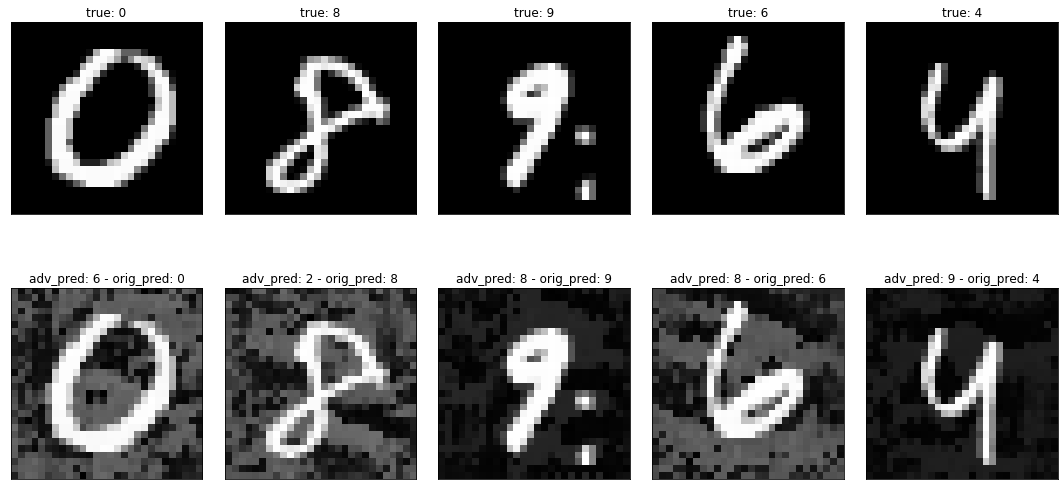

timestamp 2019-07-23 06.09.28.049504 attack cw_div4_attack layer:  relu3 regularization_weight:  10
Step 0
batch [0] loss: 0.2564767003059387
batch [100] loss: 0.16550248861312866
batch [200] loss: 0.08494803309440613
batch [300] loss: 0.03219439089298248
batch [400] loss: 0.008632460609078407
batch [500] loss: 0.0020982655696570873
batch [600] loss: 0.00037930835969746113
batch [700] loss: -9.536738616588991e-06
batch [800] loss: -9.536738616588991e-06
batch [900] loss: -9.536738616588991e-06
Step 1
batch [0] loss: -9.536738616588991e-06
batch [100] loss: -9.536738616588991e-06
batch [200] loss: -9.536738616588991e-06
batch [300] loss: -9.536738616588991e-06
batch [400] loss: -9.536738616588991e-06
batch [500] loss: -9.536738616588991e-06
batch [600] loss: -9.536738616588991e-06
batch [700] loss: -9.536738616588991e-06
batch [800] loss: -9.536738616588991e-06
batch [900] loss: -9.536738616588991e-06
Step 2
batch [0] loss: -9.536738616588991e-06
batch [100] loss: -9.536738616588991e-06

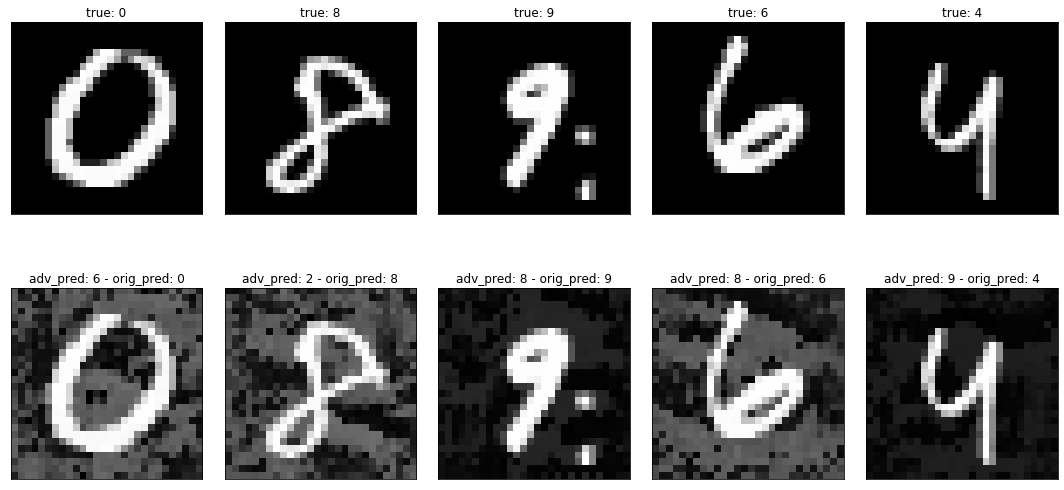

timestamp 2019-07-23 06.12.44.279442 attack cw_div4_attack layer:  relu3 regularization_weight:  100
Step 0
batch [0] loss: 0.25639086961746216
batch [100] loss: 0.1654171496629715
batch [200] loss: 0.08486217260360718
batch [300] loss: 0.032109104096889496
batch [400] loss: 0.008546534925699234
batch [500] loss: 0.002012531738728285
batch [600] loss: 0.0002934230142273009
batch [700] loss: -9.536738798487931e-05
batch [800] loss: -9.536738798487931e-05
batch [900] loss: -9.536738798487931e-05
Step 1
batch [0] loss: -9.536738798487931e-05
batch [100] loss: -9.536738798487931e-05
batch [200] loss: -9.536738798487931e-05
batch [300] loss: -9.536738798487931e-05
batch [400] loss: -9.536738798487931e-05
batch [500] loss: -9.536738798487931e-05
batch [600] loss: -9.536738798487931e-05
batch [700] loss: -9.536738798487931e-05
batch [800] loss: -9.536738798487931e-05
batch [900] loss: -9.536738798487931e-05
Step 2
batch [0] loss: -9.536738798487931e-05
batch [100] loss: -9.536738798487931e-05

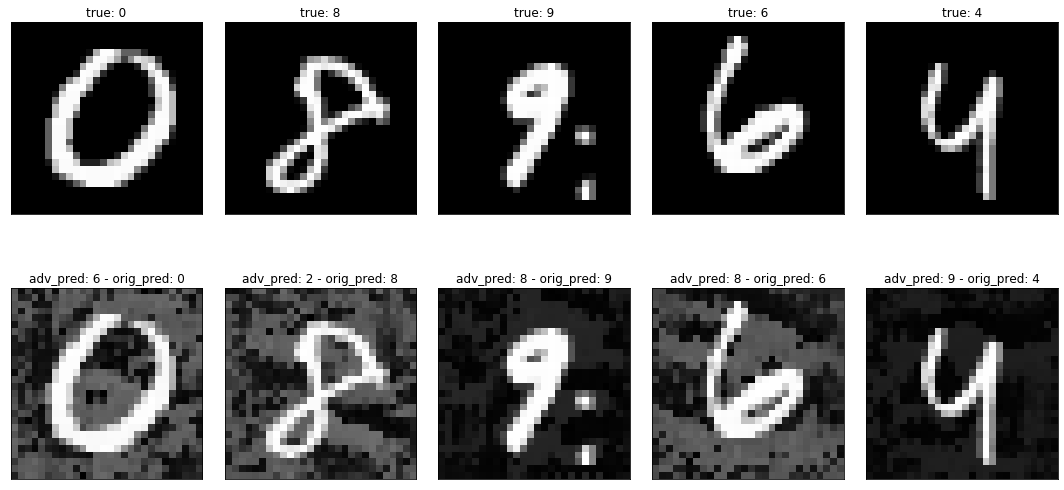

In [14]:
results = []

all_layers = list(dict(model.named_children()))
target_layers = [layer for layer in all_layers if 'relu' in layer]
attack_versions = [cw_div1_attack, cw_div2_attack, cw_div3_attack, cw_div4_attack]

for attack in attack_versions:
    for l in target_layers:
        for rw in [0, 0.001, 0.01, 1, 10, 100]:
            timestamp = str(datetime.datetime.now()).replace(':','.')
            print('timestamp', timestamp, 'attack', attack.__name__, 'layer: ', l, 'regularization_weight: ', rw)
            cw_advs_divs, divergences = attack(model, l, rw, inputs, targets, targeted=False, confidence=0.0,
                                               c_range=(1e-3, 1e10), search_steps=3, max_steps=1000, 
                                               abort_early=True, box=box, optimizer_lr=5e-4, 
                                               init_rand=False, log_frequency=100)

            pert_acc, orig_acc = eval_performance(model, inputs, cw_advs_divs)
            sample_images(inputs, cw_advs_divs)
            
            pert_acc = pert_acc.item() / 100.
            orig_acc = orig_acc.item() / 100.

            out = {'timestamp': timestamp, 'attack': attack.__name__, 'layer': l, 'regularization_weight': rw, 'adversaries': cw_advs_divs, 'divergences':divergences, 'pert_acc':pert_acc, 'orig_acc': orig_acc}
            results.append(out)

In [15]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc']]

,attack,layer,regularization_weight,orig_acc,pert_acc
0,cw_div1_attack,relu1,0.000,0.98,0.00
1,cw_div1_attack,relu1,0.001,0.98,0.00
2,cw_div1_attack,relu1,0.010,0.98,0.00
3,cw_div1_attack,relu1,1.000,0.98,0.00
4,cw_div1_attack,relu1,10.000,0.98,0.01
5,cw_div1_attack,relu1,100.000,0.98,0.01
6,cw_div1_attack,relu2,0.000,0.98,0.00
7,cw_div1_attack,relu2,0.001,0.98,0.00
8,cw_div1_attack,relu2,0.010,0.98,0.00
9,cw_div1_attack,relu2,1.000,0.98,0.00


In [16]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results.pickle", "wb" ))

In [5]:
# load the results from file
with open('assets/results.pickle', 'rb') as handle:
    results = pickle.load(handle)

# Coverage Criteria

## Neuron Coverage (DeepXplore)

In [10]:
def get_layer_output_sizes(model, data):   
    output_sizes = {}
    hooks = []  
    layers = list(dict(model.named_children()))   
    def hook(module, input, output):
        module_idx = len(output_sizes)
        m_key = layers[module_idx]
        output_sizes[m_key] = list(output.size()[1:])      
    for name, module in model.named_children():
        if (not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)):
            hooks.append(module.register_forward_hook(hook))
    try:
        out = model(data[:1])  
    finally:
        for h in hooks:
            h.remove()       
    return output_sizes

def get_init_dict(model, data, init_value=False): 
    output_sizes = get_layer_output_sizes(model, data)       
    model_layer_dict = {}  
    for layer, output_size in output_sizes.items():
        for index in range(np.prod(output_size)):
            # since we only care about post-activation outputs
            if 'relu' in layer.lower():
                model_layer_dict[(layer, index)] = init_value               
    return model_layer_dict

def neurons_covered(model_layer_dict):
    covered_neurons = len([v for v in model_layer_dict.values() if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)

def scale(out, rmax=1, rmin=0):
    output_std = (out - out.min()) / (out.max() - out.min())
    output_scaled = output_std * (rmax - rmin) + rmin
    return output_scaled

def update_coverage(model, data, model_layer_dict, threshold=0.):   
    layers = list(set([x[0] for x in list(model_layer_dict.keys())]))    
    for layer in layers:       
        outputs = torch.squeeze(model.extract_outputs(data, layer))
        scaled_outputs = scale(outputs)            
        for i, out in enumerate(scaled_outputs.view(-1)):
            if out > threshold:
                model_layer_dict[(layer, i)] = True
                
def eval_nc(model, data, threshold=0.):
    model_layer_dict = get_init_dict(model, data, False)
    update_coverage(model, data, model_layer_dict, threshold=0.)
    _, _, nc = neurons_covered(model_layer_dict)
    return nc

In [11]:
# test baseline (unperturbed) inputs
eval_nc(model, inputs, threshold=0.)

0.6015768725361367

In [25]:
for i in range(len(results)):
    a = results[i]['attack'] 
    l = results[i]['layer']
    rw = results[i]['regularization_weight']
    nc = eval_nc(model, results[i]['adversaries'], threshold=0.)
    results[i]['neuron_coverage'] = nc
    print(i, a, l, rw, nc) 

0 cw_div1_attack relu1 0 0.5850197109067017
1 cw_div1_attack relu1 0.001 0.5576215505913272
2 cw_div1_attack relu1 0.01 0.4885676741130092
3 cw_div1_attack relu1 1 0.43495400788436267
4 cw_div1_attack relu1 10 0.585611038107753
5 cw_div1_attack relu1 100 0.585611038107753
6 cw_div1_attack relu2 0 0.5851511169513798
7 cw_div1_attack relu2 0.001 0.5846911957950066
8 cw_div1_attack relu2 0.01 0.5894875164257556
9 cw_div1_attack relu2 1 0.5682654402102497
10 cw_div1_attack relu2 10 0.5706964520367936
11 cw_div1_attack relu2 100 0.5704993429697766
12 cw_div1_attack relu3 0 0.5850197109067017
13 cw_div1_attack relu3 0.001 0.5851511169513798
14 cw_div1_attack relu3 0.01 0.5850197109067017
15 cw_div1_attack relu3 1 0.5851511169513798
16 cw_div1_attack relu3 10 0.5854139290407359
17 cw_div1_attack relu3 100 0.5849540078843627
18 cw_div2_attack relu1 0 0.5852825229960578
19 cw_div2_attack relu1 0.001 0.5838370565045992
20 cw_div2_attack relu1 0.01 0.5883048620236531
21 cw_div2_attack relu1 1 0.6

In [85]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc', 'neuron_coverage']]

,attack,layer,regularization_weight,orig_acc,pert_acc,neuron_coverage
0,cw_div1_attack,relu1,0.000,0.98,0.00,0.585020
1,cw_div1_attack,relu1,0.001,0.98,0.00,0.557622
2,cw_div1_attack,relu1,0.010,0.98,0.00,0.488568
3,cw_div1_attack,relu1,1.000,0.98,0.00,0.434954
4,cw_div1_attack,relu1,10.000,0.98,0.01,0.585611
5,cw_div1_attack,relu1,100.000,0.98,0.01,0.585611
6,cw_div1_attack,relu2,0.000,0.98,0.00,0.585151
7,cw_div1_attack,relu2,0.001,0.98,0.00,0.584691
8,cw_div1_attack,relu2,0.010,0.98,0.00,0.589488
9,cw_div1_attack,relu2,1.000,0.98,0.00,0.568265


In [76]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results.pickle", "wb" ))

## k-multisection Neuron Coverage (DeepGauge)

In [13]:
# model.init_dict(model.covered_dict, inputs, 'relu', False)
# model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
# print(len(model.covered_dict), len(model.lowhigh_dict))

In [9]:
# # move this to cpu because the GPU RAM probably isn't large enough to handle it 
# device = torch.device("cpu")
# model.to(device)

model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
model.hook_lowhigh_dict('relu')

lohi_batch_size = int(len(train_loader.dataset) / 10)

lowhigh_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
    batch_size=lohi_batch_size, shuffle=True, pin_memory=True)

for i, (lohi_inputs, _) in enumerate(lowhigh_loader):
    print('batch:', i)
    lohi_inputs = lohi_inputs.to(device)
    model(lohi_inputs)

model.remove_hooks()

# device = torch.device("cuda")

pickle.dump(model.lowhigh_dict, open( "assets/lowhigh_dict.pickle", "wb" ))

{('relu1', 0): {'low': 0, 'high': 0.17005696892738342},
 ('relu1', 1): {'low': 0, 'high': 0.2610016167163849},
 ('relu1', 2): {'low': 0, 'high': 0.3574622869491577},
 ('relu1', 3): {'low': 0, 'high': 0.4250221848487854},
 ('relu1', 4): {'low': 0, 'high': 0.4433531165122986},
 ('relu1', 5): {'low': 0, 'high': 0.42099499702453613},
 ('relu1', 6): {'low': 0, 'high': 0.3878710865974426},
 ('relu1', 7): {'low': 0, 'high': 0.4209814667701721},
 ('relu1', 8): {'low': 0, 'high': 0.42347657680511475},
 ('relu1', 9): {'low': 0, 'high': 0.40517371892929077},
 ('relu1', 10): {'low': 0, 'high': 0.7064920663833618},
 ('relu1', 11): {'low': 0, 'high': 0.8078417778015137},
 ('relu1', 12): {'low': 0, 'high': 0.6157643795013428},
 ('relu1', 13): {'low': 0, 'high': 0.47518014907836914},
 ('relu1', 14): {'low': 0, 'high': 0.3899363875389099},
 ('relu1', 15): {'low': 0, 'high': 0.3532407879829407},
 ('relu1', 16): {'low': 0, 'high': 0.3282723128795624},
 ('relu1', 17): {'low': 0, 'high': 0.3503431081771850

In [5]:
# load the results from file
with open('assets/lowhigh_dict.pickle', 'rb') as handle:
    model.lowhigh_dict = pickle.load(handle)

In [6]:
get_dict_for_layer(model.lowhigh_dict, 'relu3')

{('relu3', 0): {'low': 0, 'high': 4.8202948570251465},
 ('relu3', 1): {'low': 0, 'high': 4.82769775390625},
 ('relu3', 2): {'low': 0, 'high': 7.479001522064209},
 ('relu3', 3): {'low': 0, 'high': 8.612505912780762},
 ('relu3', 4): {'low': 0, 'high': 5.791659355163574},
 ('relu3', 5): {'low': 0, 'high': 7.655079364776611},
 ('relu3', 6): {'low': 0, 'high': 6.207518100738525},
 ('relu3', 7): {'low': 0, 'high': 7.808154582977295},
 ('relu3', 8): {'low': 0, 'high': 8.590152740478516},
 ('relu3', 9): {'low': 0, 'high': 2.782480001449585},
 ('relu3', 10): {'low': 0, 'high': 1.412194848060608},
 ('relu3', 11): {'low': 0, 'high': 6.954821586608887},
 ('relu3', 12): {'low': 0, 'high': 4.98781681060791},
 ('relu3', 13): {'low': 0, 'high': 1.674249291419983},
 ('relu3', 14): {'low': 0, 'high': 3.0363736152648926},
 ('relu3', 15): {'low': 0, 'high': 5.852689743041992},
 ('relu3', 16): {'low': 0, 'high': 7.916790962219238},
 ('relu3', 17): {'low': 0, 'high': 6.889847755432129},
 ('relu3', 18): {'lo

# Inception Scoring

In [21]:
from inception_score import *
# %load_ext autoreload
# %autoreload 2

In [22]:
def preprocess_for_is(imgs):
    '''
    imgs : input expected to be a pytorch cuda tensor of images with a single dimension
    returns the input images as a 3D numpy array by replicating the single array 3 times
    '''
    adv_np = imgs.cpu().detach().numpy()
    adv_3d = np.tile(adv_np[..., None], 3)
    adv_3d = np.transpose(adv_3d, (0, 4, 2, 3, 1))
    adv_3d = np.squeeze(adv_3d)
    return adv_3d

In [18]:
for i in range(len(results)):
    a = results[i]['attack'] 
    l = results[i]['layer']
    rw = results[i]['regularization_weight']
    adv_3d = preprocess_for_is(results[i]['adversaries'])
    mean_is, std_is = inception_score(adv_3d, cuda=True, batch_size=10, resize=True, splits=10)
    results[i]['inception_score'] = mean_is
    print(i, a, l, rw, mean_is) 

0 cw_div1_attack relu1 0 2.1209492815586906
1 cw_div1_attack relu1 0.001 2.127311732225868
2 cw_div1_attack relu1 0.01 2.1292338489015177
3 cw_div1_attack relu1 1 2.1406525736513213
4 cw_div1_attack relu1 10 2.1289341141537674
5 cw_div1_attack relu1 100 2.129162888722381
6 cw_div1_attack relu2 0 2.121341867838196
7 cw_div1_attack relu2 0.001 2.1283085506669894
8 cw_div1_attack relu2 0.01 2.128306204108593
9 cw_div1_attack relu2 1 2.156900076796944
10 cw_div1_attack relu2 10 2.160886621290113
11 cw_div1_attack relu2 100 2.16015964869021
12 cw_div1_attack relu3 0 2.1206074935563985
13 cw_div1_attack relu3 0.001 2.1211123572604844
14 cw_div1_attack relu3 0.01 2.1215065538287528
15 cw_div1_attack relu3 1 2.121403170482811
16 cw_div1_attack relu3 10 2.1203692489550567
17 cw_div1_attack relu3 100 2.1208818906729934
18 cw_div2_attack relu1 0 2.150741244827747
19 cw_div2_attack relu1 0.001 2.1565648058678675
20 cw_div2_attack relu1 0.01 2.1564078357085883
21 cw_div2_attack relu1 1 2.1597769637

In [23]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc', 'inception_score']]

,attack,layer,regularization_weight,orig_acc,pert_acc,inception_score
0,cw_div1_attack,relu1,0.000,0.98,0.00,2.120949
1,cw_div1_attack,relu1,0.001,0.98,0.00,2.127312
2,cw_div1_attack,relu1,0.010,0.98,0.00,2.129234
3,cw_div1_attack,relu1,1.000,0.98,0.00,2.140653
4,cw_div1_attack,relu1,10.000,0.98,0.01,2.128934
5,cw_div1_attack,relu1,100.000,0.98,0.01,2.129163
6,cw_div1_attack,relu2,0.000,0.98,0.00,2.121342
7,cw_div1_attack,relu2,0.001,0.98,0.00,2.128309
8,cw_div1_attack,relu2,0.010,0.98,0.00,2.128306
9,cw_div1_attack,relu2,1.000,0.98,0.00,2.156900


In [30]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results.pickle", "wb" ))

In [20]:
# plt.imshow(adv_np[0].reshape(28, 28))
# plt.imshow(adv_3d[0].transpose((1,2,0)))